In [1]:
import sys,os

data_path = os.getcwd()

try:
    import localgraphclustering as lgc
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    import localgraphclustering as lgc

In [2]:
import time
import numpy as np

import matplotlib.pyplot as plt

# Import the graph_tool module for visualization.
from graph_tool.all import * 

import statistics as stat_

# Load graph

In [3]:
# Read graph. This also supports gml format.
#g = lgc.GraphLocal(os.path.join(data_path,'datasets/JohnsHopkins.graphml'),'graphml')
g = lgc.GraphLocal(os.path.join(data_path,'datasets/Rice31_reduced.graphml'),'graphml')
# To get a quick look at the list of methods and attributes for the graph object 'g' you can type 'g.' + tab
# and scroll up or down.

vol_G = g.vol_G

/usr/local/lib/python3.7/site-packages/localgraphclustering/GraphLocal.py:217: UserWarning:

Loading a graphml is not efficient, we suggest using an edgelist format for this API.



## Load graph using GraphTool. We do this to handle some meta-data which LocalGraphClustering is not handling yet.

In [4]:
g_gtool = load_graph('datasets/Rice31_reduced.graphml')
remove_self_loops(g_gtool)

n = g_gtool.num_vertices()

## Load coordinates for graph layout

In [5]:
# Load pre-computed coordinates for nodes.
g_v_prop = g_gtool.vertex_properties
xx = g_v_prop.x
yy = g_v_prop.y

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(n):
    pos[i] = [xx[i],yy[i]]

## Load and filter ground truth clusters. This part takes a while to run. The results are saved in results/

In [6]:
g_v_prop = g_gtool.vertex_properties
#feature_list = [g_v_prop.secondMajor,g_v_prop.highSchool,g_v_prop.gender,g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]
feature_list = [g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]

number_feature = 0

ref_nodes = []
info_ref_nodes = []

for kk in feature_list:
    
    feature = kk

    for ff in list(set(feature.a)):
        
        if ff == 0:
            continue

        feature_array = np.zeros(n)
        feature_ff_nodes = []
        for i in range(n):
            feature_array[i] = feature[i]
            if feature_array[i] == ff:
                feature_ff_nodes.append(i)

        g_ff = g_gtool.copy()

        del_list_ff = list(set(range(n)) - set(feature_ff_nodes))

        for v in reversed(sorted(del_list_ff)):
            g_ff.remove_vertex(v)   

        n_ff = g_ff.num_vertices() 

        comp_ff,hist_ff=label_components(g_ff)

        feature_ff_nodes_largest_component = []
        for i in range(n_ff):
            if comp_ff[i] == 0:
                feature_ff_nodes_largest_component.append(feature_ff_nodes[i])    

        vol_ff = sum(g.d[feature_ff_nodes_largest_component])
        
        if vol_ff < 1000:
            continue
            
        #temp = np.zeros(n)
        #temp[feature_ff_nodes_largest_component] = 1
        
        #cut_ff = vol_ff - (g.adjacency_matrix.dot(temp).transpose()).dot(temp)
        #cond_ff = cut_ff/min(vol_ff,vol_G - vol_ff)
        cond_ff = g.compute_conductance(feature_ff_nodes_largest_component,cpp=True)
        
        if cond_ff > 0.47:
            continue
            
        print("Reached")
        eig_ff, lambda_ff = lgc.fiedler_local(g, feature_ff_nodes_largest_component)
        lambda_ff = np.real(lambda_ff)
        gap_ff = lambda_ff/cond_ff
        
        print("Number of feature", number_feature, "Feature value ", ff, " gap ",gap_ff, " volume: ", vol_ff, " size:", len(feature_ff_nodes_largest_component), "conductance: ", cond_ff)
        
        if gap_ff >= 0.5 and vol_ff >= 1000:
            ref_nodes.append(feature_ff_nodes_largest_component)
            info_ref_nodes.append([number_feature,ff])
            np.save('results/ref_nodes_Rice31', ref_nodes) 
            np.save('results/info_ref_nodes_Rice31', info_ref_nodes) 
        
    number_feature += 1

Reached
Number of feature 0 Feature value  203  gap  [0.83267026]  volume:  43321.0  size: 403 conductance:  0.46275478405392306
Reached
Number of feature 2 Feature value  2009  gap  [0.91440611]  volume:  30858.0  size: 607 conductance:  0.3385183744895975


## If you have generated the ground truth datasets once, you can avoid rerunning the above code and simple run the code below.

In [7]:
ref_nodes = np.load('results/ref_nodes_Rice31.npy') 
info_ref_nodes = np.load('results/info_ref_nodes_Rice31.npy') 

## Visualize the ground truth clusters

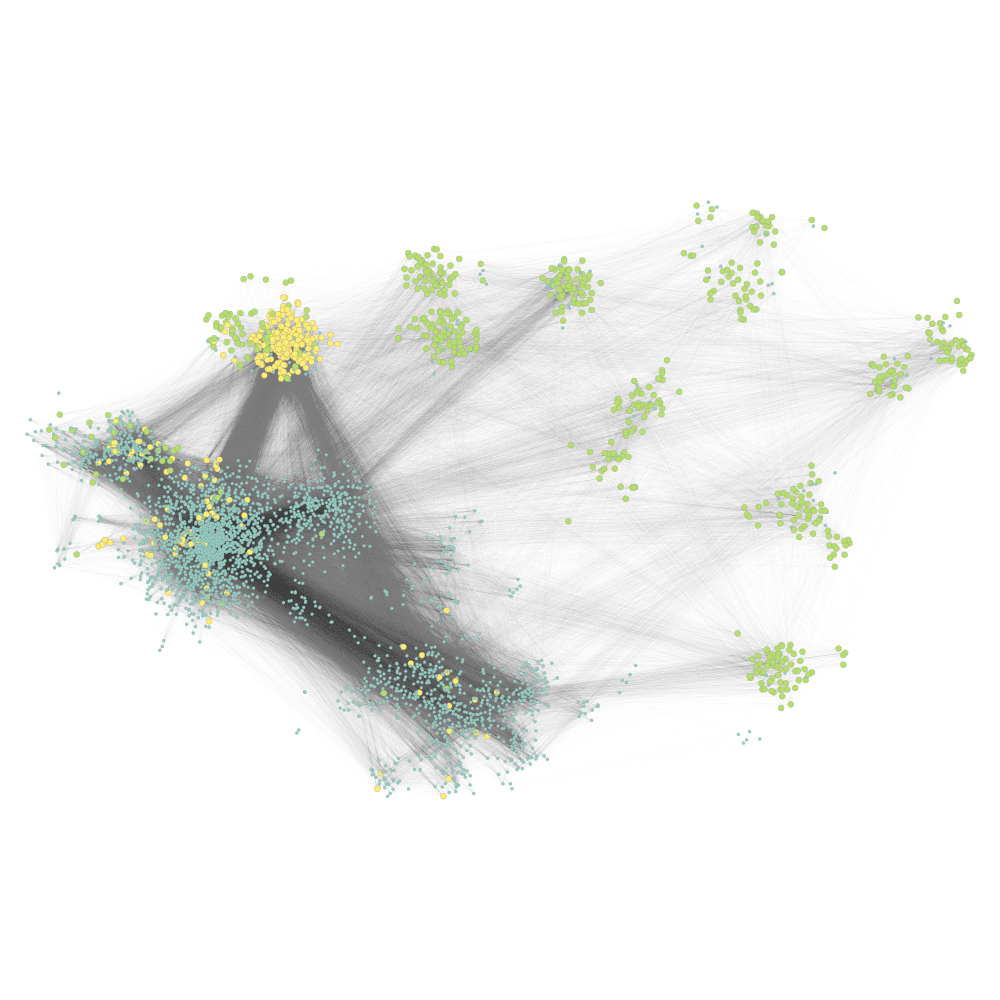

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1414fc390, at 0x13d1bd668>

In [8]:
temp = np.zeros(n)
temp = temp + 3

temp2 = np.zeros(n, dtype=int)

counter = 0

for i in ref_nodes:
        
    temp[i] = 6
    
    for j in i:
        temp2[j] = int(info_ref_nodes[counter,1])
    counter += 1

node_size = g_gtool.new_vertex_property("double",temp)

node_colours = g_gtool.new_vertex_property("int",temp2)

c_map = plt.get_cmap('Dark2')

graph_draw(g_gtool, pos, output_size=(1000, 1000),
            vertex_size=node_size, 
            vertex_fill_color=node_colours,
            edge_pen_width=0.1,
            edge_color = [0.0, 0, 0, 0.05]
            )

## Results by spectral algorithm: https://dl.acm.org/citation.cfm?id=1170528 

In [9]:
nodes = {}
external_best_cond_acl = {}
external_best_pre_cond_acl = {}
gap_best_cond_acl = {}
gap_best_pre_acl = {}
vol_best_cond_acl = {}
vol_best_pre_acl = {}
size_clust_best_cond_acl = {}
size_clust_best_pre_acl = {}
f1score_best_cond_acl = {}
f1score_best_pre_acl = {}
true_positives_best_cond_acl = {}
true_positives_best_pre_acl = {}
precision_best_cond_acl = {}
precision_best_pre_acl = {}
recall_best_cond_acl = {}
recall_best_pre_acl = {}
cuts_best_cond_acl = {}
cuts_best_pre_acl = {}
cuts_acl_ALL = {}

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)
    
    nodes[ct_outer] = np.random.choice(rr, how_many, replace=False)
    
    eigv, lambda_val = lgc.fiedler_local(g, rr)
    lambda_val = np.real(lambda_val)
    
    step = (2*lambda_val - lambda_val/2)/4
    
    a_list = np.arange(lambda_val/2,2*lambda_val,step)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        max_precision = -1
        min_conduct = 100
        
        ct_inner = 0
        for a in a_list:

            output_pr_clustering = lgc.spectral_clustering(g,ref_node,method="l1reg",alpha=a,rho=2.0e-7,epsilon=1.0e-2,iterations=1000)
            
            S_l1pr = output_pr_clustering[0]
            
            cuts_acl_ALL[ct_outer,node,ct_inner] = S_l1pr
            
            size_clust_acl_ = len(S_l1pr)
            
            cond_val_l1pr = output_pr_clustering[1]
            
            vol_ = sum(g.d[S_l1pr])
            true_positives_acl_ = set(rr).intersection(S_l1pr)
            if len(true_positives_acl_) == 0:
                true_positives_acl_ = set(ref_node)
                vol_ = g.d[ref_node][0,0]
            precision = sum(g.d[np.array(list(true_positives_acl_))])/vol_
            recall = sum(g.d[np.array(list(true_positives_acl_))])/sum(g.d[rr])
            f1_score_ = 2*(precision*recall)/(precision + recall)
            
            if f1_score_ >= max_precision:
            
                max_precision = f1_score_
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_pre_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_pre_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_pre_acl[ct_outer,node] = vol_

                size_clust_best_pre_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_pre_acl[ct_outer,node] = true_positives_acl_
                precision_best_pre_acl[ct_outer,node] = precision
                recall_best_pre_acl[ct_outer,node] = recall
                f1score_best_pre_acl[ct_outer,node] = f1_score_
                
                cuts_best_pre_acl[ct_outer,node] = S_l1pr
                
            if cond_val_l1pr <= min_conduct:
            
                min_conduct = cond_val_l1pr
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_cond_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_cond_acl[ct_outer,node] = vol_

                size_clust_best_cond_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_cond_acl[ct_outer,node] = true_positives_acl_
                precision_best_cond_acl[ct_outer,node] = precision
                recall_best_cond_acl[ct_outer,node] = recall
                f1score_best_cond_acl[ct_outer,node] = f1_score_
                
                cuts_best_cond_acl[ct_outer,node] = S_l1pr

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', external_best_cond_acl[ct_outer,node], 'f1score: ', f1score_best_pre_acl[ct_outer,node], 'precision: ', precision_best_pre_acl[ct_outer,node], 'recall: ', recall_best_pre_acl[ct_outer,node])
        ct += 1
    ct_outer += 1
    
    np.save('results/size_clust_best_cond_acl_Rice31', size_clust_best_cond_acl) 
    np.save('results/external_best_cond_acl_Rice31', external_best_cond_acl)
    np.save('results/vol_best_cond_acl_Rice31', vol_best_cond_acl) 
    np.save('results/gap_best_cond_acl_Rice31', gap_best_cond_acl) 
    np.save('results/cuts_best_cond_acl_Rice31', cuts_best_cond_acl) 
    np.save('results/true_positives_best_cond_acl_Rice31', true_positives_best_cond_acl)
    np.save('results/f1score_best_cond_acl_Rice31', f1score_best_cond_acl) 
    np.save('results/precision_best_cond_acl_Rice31', precision_best_cond_acl) 
    np.save('results/recall_best_cond_acl_Rice31', recall_best_cond_acl) 

    np.save('results/size_clust_best_pre_acl_Rice31', size_clust_best_pre_acl) 
    np.save('results/external_best_pre_cond_acl_Rice31', external_best_pre_cond_acl)
    np.save('results/vol_best_pre_acl_Rice31', vol_best_pre_acl) 
    np.save('results/gap_best_pre_acl_Rice31', gap_best_pre_acl) 
    np.save('results/cuts_best_pre_acl_Rice31', cuts_best_pre_acl) 
    np.save('results/true_positives_best_pre_acl_Rice31', true_positives_best_pre_acl)
    np.save('results/f1score_best_pre_acl_Rice31', f1score_best_pre_acl) 
    np.save('results/precision_best_pre_acl_Rice31', precision_best_pre_acl) 
    np.save('results/recall_best_pre_acl_Rice31', recall_best_pre_acl) 

    np.save('results/cuts_acl_ALL_Rice31', cuts_acl_ALL) 
    
    np.save('results/nodes_Rice31', nodes)

201
outer: 0 number of node:  1449  completed:  0.0  degree:  79.0
conductance:  0.3256092083403233 f1score:  0.6083051026381705 precision:  0.5205814717477004 recall:  0.7315851434639089
outer: 0 number of node:  2613  completed:  0.004975124378109453  degree:  191.0
conductance:  0.36256920653991653 f1score:  0.732744767384188 precision:  0.6424533388996155 recall:  0.8525657302463009
outer: 0 number of node:  1935  completed:  0.009950248756218905  degree:  179.0
conductance:  0.34395462859740455 f1score:  0.6413091050558428 precision:  0.49416070246437094 recall:  0.9132522333279471
outer: 0 number of node:  1688  completed:  0.014925373134328358  degree:  110.0
conductance:  0.3152282175645245 f1score:  0.3066650916019949 precision:  0.19721231338353812 recall:  0.6891345998476489
outer: 0 number of node:  390  completed:  0.01990049751243781  degree:  110.0
conductance:  0.29550571527537234 f1score:  0.5111313107230137 precision:  0.37736949227130206 recall:  0.7917868931926779
o

outer: 0 number of node:  1481  completed:  0.20398009950248755  degree:  56.0
conductance:  0.2940202571094663 f1score:  0.3657352161230443 precision:  0.2852839653010304 recall:  0.509383439902126
outer: 0 number of node:  3848  completed:  0.208955223880597  degree:  44.0
conductance:  0.3304663846657965 f1score:  0.5683802324780268 precision:  0.49543582704186684 recall:  0.6665127767133723
outer: 0 number of node:  1764  completed:  0.21393034825870647  degree:  125.0
conductance:  0.3328571660471081 f1score:  0.5843568309202326 precision:  0.46945378151260503 recall:  0.7737356016712449
outer: 0 number of node:  1093  completed:  0.21890547263681592  degree:  3.0
conductance:  0.31829495281793785 f1score:  0.31483875445735254 precision:  0.25221718702215795 recall:  0.4188268968860368
outer: 0 number of node:  2603  completed:  0.22388059701492538  degree:  35.0
conductance:  0.3238134919131851 f1score:  0.49096767114542494 precision:  0.4322852626031969 recall:  0.56808476258627

outer: 0 number of node:  2273  completed:  0.4079601990049751  degree:  119.0
conductance:  0.32981952974918155 f1score:  0.5748978596255869 precision:  0.4291632051530084 recall:  0.8705016043027631
outer: 0 number of node:  3562  completed:  0.4129353233830846  degree:  58.0
conductance:  0.3350575707730932 f1score:  0.42871435341552766 precision:  0.3179789323335119 recall:  0.6577872163615799
outer: 0 number of node:  51  completed:  0.417910447761194  degree:  76.0
conductance:  0.3442316017316017 f1score:  0.7588784573086522 precision:  0.8410941976071449 recall:  0.6913044481891
outer: 0 number of node:  2975  completed:  0.4228855721393035  degree:  123.0
conductance:  0.3291259140582291 f1score:  0.5356639635822602 precision:  0.4673016091321689 recall:  0.6274555065672538
outer: 0 number of node:  2041  completed:  0.42786069651741293  degree:  17.0
conductance:  0.33945539946752096 f1score:  0.5678014677554242 precision:  0.47881141045958797 recall:  0.6974215738325523
oute

outer: 0 number of node:  1588  completed:  0.6169154228855721  degree:  106.0
conductance:  0.30720368787265584 f1score:  0.3900452934226073 precision:  0.247892665160608 recall:  0.9144064079776552
outer: 0 number of node:  967  completed:  0.6218905472636815  degree:  34.0
conductance:  0.335570542451043 f1score:  0.6377481779341543 precision:  0.5648751647255761 recall:  0.7322083977747513
outer: 0 number of node:  40  completed:  0.6268656716417911  degree:  85.0
conductance:  0.3253150305287317 f1score:  0.3021075905204664 precision:  0.2375776808144916 recall:  0.4147642021190647
outer: 0 number of node:  2641  completed:  0.6318407960199005  degree:  108.0
conductance:  0.3547761452780306 f1score:  0.7946698970321018 precision:  0.7598348917530116 recall:  0.8328524272292883
outer: 0 number of node:  2310  completed:  0.6368159203980099  degree:  52.0
conductance:  0.31373812295281667 f1score:  0.40944307720353657 precision:  0.294032345773499 recall:  0.67399182844348
outer: 0

outer: 0 number of node:  2172  completed:  0.8258706467661692  degree:  38.0
conductance:  0.3048547473030685 f1score:  0.28994072463259796 precision:  0.17896052866583317 recall:  0.7632787793448905
outer: 0 number of node:  3803  completed:  0.8308457711442786  degree:  17.0
conductance:  0.3557208949974297 f1score:  0.59438724947242 precision:  0.600499434602337 recall:  0.5883982364211352
outer: 0 number of node:  955  completed:  0.835820895522388  degree:  133.0
conductance:  0.35404015803431294 f1score:  0.6861599120710409 precision:  0.5514814139686189 recall:  0.9078737794603079
outer: 0 number of node:  555  completed:  0.8407960199004975  degree:  99.0
conductance:  0.34173351086285847 f1score:  0.7399558609620304 precision:  0.8099761166167952 recall:  0.6810784607926872
outer: 0 number of node:  973  completed:  0.845771144278607  degree:  238.0
conductance:  0.3466541141843051 f1score:  0.6017065655368572 precision:  0.4574108998306286 recall:  0.878996329724614
outer: 0

outer: 1 number of node:  2438  completed:  0.0231023102310231  degree:  65.0
conductance:  0.30741422231843274 f1score:  0.34513547356768237 precision:  0.21217395184862886 recall:  0.9244604316546763
outer: 1 number of node:  1312  completed:  0.026402640264026403  degree:  59.0
conductance:  0.3136881099641468 f1score:  0.4623735464882513 precision:  0.3074890904423719 recall:  0.9316546762589928
outer: 1 number of node:  1053  completed:  0.0297029702970297  degree:  9.0
conductance:  0.2909860466123253 f1score:  0.45182646532464643 precision:  0.35350965498306947 recall:  0.6258992805755396
outer: 1 number of node:  2749  completed:  0.033003300330033  degree:  111.0
conductance:  0.3210231425091352 f1score:  0.3515675648457612 precision:  0.2181551175997313 recall:  0.9050489338259122
outer: 1 number of node:  2710  completed:  0.036303630363036306  degree:  204.0
conductance:  0.3058090073708478 f1score:  0.34759925922580065 precision:  0.2104694572456138 recall:  0.997537105450

outer: 1 number of node:  974  completed:  0.15841584158415842  degree:  32.0
conductance:  0.3259175056836635 f1score:  0.3053753969212408 precision:  0.19555466596307988 recall:  0.696545466329639
outer: 1 number of node:  3640  completed:  0.1617161716171617  degree:  82.0
conductance:  0.2989225432525015 f1score:  0.8011632133769538 precision:  0.7265870190152175 recall:  0.8927992740942381
outer: 1 number of node:  1373  completed:  0.16501650165016502  degree:  24.0
conductance:  0.3123551956347574 f1score:  0.3714469361519782 precision:  0.2382239240761437 recall:  0.8427312204290621
outer: 1 number of node:  507  completed:  0.16831683168316833  degree:  23.0
conductance:  0.31521556785774196 f1score:  0.31375066125903717 precision:  0.20051930722973033 recall:  0.7207531272279474
outer: 1 number of node:  608  completed:  0.1716171617161716  degree:  29.0
conductance:  0.30757072177895184 f1score:  0.30161494957314583 precision:  0.19363834663279675 recall:  0.6818005055415127

outer: 1 number of node:  420  completed:  0.29372937293729373  degree:  48.0
conductance:  0.30873918906477626 f1score:  0.4174108962624234 precision:  0.2705897049073211 recall:  0.9125672435024953
outer: 1 number of node:  967  completed:  0.297029702970297  degree:  34.0
conductance:  0.33314568425155083 f1score:  0.2859274776611917 precision:  0.16682169704180413 recall:  0.9996435284205069
outer: 1 number of node:  635  completed:  0.30033003300330036  degree:  77.0
conductance:  0.30582555798497607 f1score:  0.3769398095339152 precision:  0.2369632285499875 recall:  0.920960528874198
outer: 1 number of node:  2195  completed:  0.30363036303630364  degree:  51.0
conductance:  0.32176878112145485 f1score:  0.4414570491705765 precision:  0.2864531568129843 recall:  0.9620195735303649
outer: 1 number of node:  67  completed:  0.3069306930693069  degree:  85.0
conductance:  0.3119831132279714 f1score:  0.3468675810748843 precision:  0.21127696735279766 recall:  0.9682740294251085
out

outer: 1 number of node:  1698  completed:  0.429042904290429  degree:  50.0
conductance:  0.32410314144060276 f1score:  0.3609965793809432 precision:  0.2432843728511684 recall:  0.6993972389655843
outer: 1 number of node:  3080  completed:  0.43234323432343236  degree:  10.0
conductance:  0.31490379412592256 f1score:  0.3045784387100973 precision:  0.18289823354697515 recall:  0.9099747229243632
outer: 1 number of node:  3405  completed:  0.43564356435643564  degree:  46.0
conductance:  0.31002232481522424 f1score:  0.7553415985228172 precision:  0.7687764279481845 recall:  0.7423682675481237
outer: 1 number of node:  625  completed:  0.4389438943894389  degree:  46.0
conductance:  0.3287686062246279 f1score:  0.40748001809681794 precision:  0.25839824732229794 recall:  0.9631862077905243
outer: 1 number of node:  860  completed:  0.44224422442244227  degree:  108.0
conductance:  0.31724317070003033 f1score:  0.25821674593682487 precision:  0.15065995888780698 recall:  0.902553632769

outer: 1 number of node:  2813  completed:  0.5643564356435643  degree:  78.0
conductance:  0.3143367333134926 f1score:  0.7257197434847863 precision:  0.6267439668174962 recall:  0.8618186531855596
outer: 1 number of node:  3379  completed:  0.5676567656765676  degree:  51.0
conductance:  0.3096002555592253 f1score:  0.3563651259282751 precision:  0.22381284336669488 recall:  0.8739710933955538
outer: 1 number of node:  226  completed:  0.570957095709571  degree:  78.0
conductance:  0.3038998706716955 f1score:  0.36975789507709217 precision:  0.23095124649712906 recall:  0.9267612936677685
outer: 1 number of node:  1703  completed:  0.5742574257425742  degree:  61.0
conductance:  0.3175567809772227 f1score:  0.3420191765369431 precision:  0.209366391184573 recall:  0.9334370341564586
outer: 1 number of node:  3575  completed:  0.5775577557755776  degree:  17.0
conductance:  0.3218695028551325 f1score:  0.33772568894520116 precision:  0.2234704785060049 recall:  0.6910363601011082
oute

outer: 1 number of node:  3809  completed:  0.7029702970297029  degree:  43.0
conductance:  0.3034030251518531 f1score:  0.7763302041022703 precision:  0.8088147497805093 recall:  0.7463542679370018
outer: 1 number of node:  1270  completed:  0.7062706270627063  degree:  18.0
conductance:  0.3163736829274899 f1score:  0.33422386679000926 precision:  0.2165690007384887 recall:  0.7317713396850087
outer: 1 number of node:  2985  completed:  0.7095709570957096  degree:  110.0
conductance:  0.30542247917241827 f1score:  0.3546313891141477 precision:  0.21803190856054291 recall:  0.9495106617408776
outer: 1 number of node:  334  completed:  0.7128712871287128  degree:  66.0
conductance:  0.31976523838915416 f1score:  0.378150673447717 precision:  0.2410362823504266 recall:  0.8770821180893124
outer: 1 number of node:  3364  completed:  0.7161716171617162  degree:  91.0
conductance:  0.3135540388900032 f1score:  0.34325867894626677 precision:  0.21046957618604106 recall:  0.9300343508976603


outer: 1 number of node:  3220  completed:  0.8415841584158416  degree:  44.0
conductance:  0.31234300563014294 f1score:  0.3433619962906761 precision:  0.21679995230673582 recall:  0.8249400479616307
outer: 1 number of node:  2041  completed:  0.8448844884488449  degree:  17.0
conductance:  0.33392142006710684 f1score:  0.2837157558058684 precision:  0.16553615474490457 recall:  0.991736340657204
outer: 1 number of node:  627  completed:  0.8481848184818482  degree:  31.0
conductance:  0.31107647007880834 f1score:  0.31554951301555306 precision:  0.19260430378297946 recall:  0.8724803940631278
outer: 1 number of node:  1767  completed:  0.8514851485148515  degree:  3.0
conductance:  0.30236131852909987 f1score:  0.6061363382795939 precision:  0.46219288096372424 recall:  0.8802903623047508
outer: 1 number of node:  1288  completed:  0.8547854785478548  degree:  65.0
conductance:  0.3290626268091438 f1score:  0.36471012997730556 precision:  0.2276451555784492 recall:  0.916585650398600

outer: 1 number of node:  2381  completed:  0.9801980198019802  degree:  72.0
conductance:  0.31885837954822127 f1score:  0.414396820266674 precision:  0.2630081265329993 recall:  0.9764404692462246
outer: 1 number of node:  2626  completed:  0.9834983498349835  degree:  39.0
conductance:  0.3084081809327995 f1score:  0.30726709253051676 precision:  0.19088894477100557 recall:  0.7871864670425821
outer: 1 number of node:  1826  completed:  0.9867986798679867  degree:  101.0
conductance:  0.3200184027495873 f1score:  0.36811924531032364 precision:  0.22613623735970664 recall:  0.9892086330935251
outer: 1 number of node:  496  completed:  0.9900990099009901  degree:  22.0
conductance:  0.31988138913238745 f1score:  0.43686665059479773 precision:  0.2937999664560854 recall:  0.8515133838874847
outer: 1 number of node:  2035  completed:  0.9933993399339934  degree:  113.0
conductance:  0.30772020416889945 f1score:  0.320954276073885 precision:  0.1926167265930243 recall:  0.961760321472551

## Improve the results found by the spectral algorithm using MQI

In [10]:
nodes = np.load('results/nodes_Rice31.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_Rice31.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="mqi")
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_mqi_Rice31', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_mqi_Rice31', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_mqi_Rice31', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_mqi_Rice31', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_mqi_Rice31', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_mqi_Rice31', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_mqi_Rice31', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_mqi_Rice31', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_mqi_Rice31', f1score_acl_flow) 

201
outer: 0 number of node:  1449  completed:  0.0  degree:  79.0
conductance:  0.4533632286995516 f1score:  0.6601357421980711 precision:  0.62152466367713 recall:  0.703861868377923
outer: 0 number of node:  2613  completed:  0.004975124378109453  degree:  191.0
conductance:  0.4591731266149871 f1score:  0.8838712037161215 precision:  0.936640826873385 recall:  0.8367304540523072
outer: 0 number of node:  1935  completed:  0.009950248756218905  degree:  179.0
conductance:  0.43472239096100107 f1score:  0.9088025001183768 precision:  0.9327177742680112 recall:  0.886082962073821
outer: 0 number of node:  1688  completed:  0.014925373134328358  degree:  110.0
conductance:  0.38447507953340404 f1score:  0.3205914348030806 precision:  0.2093884764934606 recall:  0.6836868955010272
outer: 0 number of node:  390  completed:  0.01990049751243781  degree:  110.0
conductance:  0.4902420167279713 f1score:  0.5255076270330337 precision:  0.396094463838062 recall:  0.7805221486115279
outer: 0 n

outer: 0 number of node:  1481  completed:  0.20398009950248755  degree:  56.0
conductance:  0.5449466878402904 f1score:  0.38429850064559196 precision:  0.3101746823956443 recall:  0.5049744927402414
outer: 0 number of node:  3848  completed:  0.208955223880597  degree:  44.0
conductance:  0.45478829971951384 f1score:  0.12663038521176004 precision:  0.1854325274920974 recall:  0.09614274832067589
outer: 0 number of node:  1764  completed:  0.21393034825870647  degree:  125.0
conductance:  0.4395153596641862 f1score:  0.6270983777880297 precision:  0.5295268078610952 recall:  0.7687495671845064
outer: 0 number of node:  1093  completed:  0.21890547263681592  degree:  3.0
conductance:  0.5782215288611544 f1score:  0.3309967324824755 precision:  0.27734789391575665 recall:  0.4103783384501743
outer: 0 number of node:  2603  completed:  0.22388059701492538  degree:  35.0
conductance:  0.5198136665512574 f1score:  0.6097320620039418 precision:  0.720562777375594 recall:  0.528450405115302

outer: 0 number of node:  3562  completed:  0.4129353233830846  degree:  58.0
conductance:  0.5410842141152403 f1score:  0.43991961239464705 precision:  0.3319891366965682 recall:  0.6518316751690866
outer: 0 number of node:  51  completed:  0.417910447761194  degree:  76.0
conductance:  0.47253558957829706 f1score:  0.7799466520757814 precision:  0.9571917808219178 recall:  0.6580873017705039
outer: 0 number of node:  2975  completed:  0.4228855721393035  degree:  123.0
conductance:  0.42143301212309603 f1score:  0.12062499094950549 precision:  0.16183556108175318 recall:  0.09614274832067589
outer: 0 number of node:  2041  completed:  0.42786069651741293  degree:  17.0
conductance:  0.48470134362112544 f1score:  0.7722955756312253 precision:  0.9424970067846216 recall:  0.6541631079614967
outer: 0 number of node:  3838  completed:  0.43283582089552236  degree:  230.0
conductance:  0.43022782262894377 f1score:  0.9156635004232108 precision:  0.9329707974989818 recall:  0.8989866346575

outer: 0 number of node:  967  completed:  0.6218905472636815  degree:  34.0
conductance:  0.46599861347450683 f1score:  0.8061554859769502 precision:  0.9533308123778912 recall:  0.6983449135523188
outer: 0 number of node:  40  completed:  0.6268656716417911  degree:  85.0
conductance:  0.525920471281296 f1score:  0.17074105077964274 precision:  0.22153902798232694 recall:  0.13889337734585996
outer: 0 number of node:  2641  completed:  0.6318407960199005  degree:  108.0
conductance:  0.46008050542478607 f1score:  0.8654773981245517 precision:  0.932476741396316 recall:  0.8074605849357125
outer: 0 number of node:  2310  completed:  0.6368159203980099  degree:  52.0
conductance:  0.517844939708573 f1score:  0.432251374517893 precision:  0.3193241187752133 recall:  0.6687518755338058
outer: 0 number of node:  173  completed:  0.6417910447761194  degree:  171.0
conductance:  0.44008327409363257 f1score:  0.8981852035449589 precision:  0.9430283335025896 recall:  0.8574132637750744
outer

outer: 0 number of node:  955  completed:  0.835820895522388  degree:  133.0
conductance:  0.4464352092781206 f1score:  0.9081674116212921 precision:  0.9415656828488588 recall:  0.8770573163131045
outer: 0 number of node:  555  completed:  0.8407960199004975  degree:  99.0
conductance:  0.4729241877256318 f1score:  0.7847212775797806 precision:  0.9553207697148346 recall:  0.6658202719235474
outer: 0 number of node:  973  completed:  0.845771144278607  degree:  238.0
conductance:  0.4474165059384834 f1score:  0.8961740707162285 precision:  0.940716678509796 recall:  0.8556589183075183
outer: 0 number of node:  1153  completed:  0.8507462686567164  degree:  196.0
conductance:  0.44237975463271906 f1score:  0.8822235455683434 precision:  0.9315743544992556 recall:  0.8378384617160268
outer: 0 number of node:  742  completed:  0.8557213930348259  degree:  52.0
conductance:  0.509667656784173 f1score:  0.8399255762147658 precision:  0.929776382895253 recall:  0.7659102975462247
outer: 0 n

outer: 1 number of node:  1053  completed:  0.0297029702970297  degree:  9.0
conductance:  0.4733337227641802 f1score:  0.6831189945182066 precision:  0.957240493019452 recall:  0.5310454339231317
outer: 1 number of node:  2749  completed:  0.033003300330033  degree:  111.0
conductance:  0.3578024782564895 f1score:  0.9175915695037683 precision:  0.93421538668189 recall:  0.9015490310454339
outer: 1 number of node:  2710  completed:  0.036303630363036306  degree:  204.0
conductance:  0.30437165124208476 f1score:  0.9581515084921357 precision:  0.929128105211885 recall:  0.9890466005573919
outer: 1 number of node:  313  completed:  0.039603960396039604  degree:  48.0
conductance:  0.34751918158567774 f1score:  0.92524467042188 precision:  0.9494288150042626 recall:  0.9022619742044202
outer: 1 number of node:  1854  completed:  0.0429042904290429  degree:  31.0
conductance:  0.44953642384105963 f1score:  0.712766171355036 precision:  0.9390198675496689 recall:  0.5743729340851643
outer:

outer: 1 number of node:  507  completed:  0.16831683168316833  degree:  23.0
conductance:  0.44253936515871034 f1score:  0.7576037591176297 precision:  0.9631092226943264 recall:  0.6243761747358869
outer: 1 number of node:  608  completed:  0.1716171617161716  degree:  29.0
conductance:  0.4624383368569415 f1score:  0.7734499357536007 precision:  0.9473807845900869 recall:  0.6534772182254197
outer: 1 number of node:  1358  completed:  0.17491749174917492  degree:  99.0
conductance:  0.4396321333123723 f1score:  0.852900429824873 precision:  0.9436409369595975 recall:  0.7780802385118932
outer: 1 number of node:  1816  completed:  0.1782178217821782  degree:  91.0
conductance:  0.359361432102064 f1score:  0.9206907894736842 precision:  0.9347738961993187 recall:  0.907025730766738
outer: 1 number of node:  254  completed:  0.18151815181518152  degree:  47.0
conductance:  0.37998859749144814 f1score:  0.9037032008417909 precision:  0.9486887115165337 recall:  0.8627908484023592
outer:

outer: 1 number of node:  67  completed:  0.3069306930693069  degree:  85.0
conductance:  0.32493289120480023 f1score:  0.9472354173664093 precision:  0.9351650086846676 recall:  0.9596214919955928
outer: 1 number of node:  3290  completed:  0.3102310231023102  degree:  47.0
conductance:  0.3128240364794803 f1score:  0.9491061772377378 precision:  0.9319132987694422 recall:  0.9669453626288159
outer: 1 number of node:  475  completed:  0.31353135313531355  degree:  63.0
conductance:  0.41679785766452976 f1score:  0.520065316362614 precision:  0.39026211149882334 recall:  0.7792468727720526
outer: 1 number of node:  1601  completed:  0.31683168316831684  degree:  32.0
conductance:  0.45355575523173286 f1score:  0.4172449349274029 precision:  0.29245614720475055 recall:  0.7277853392961307
outer: 1 number of node:  2160  completed:  0.3201320132013201  degree:  69.0
conductance:  0.32370729235933 f1score:  0.9478050577363507 precision:  0.9369557645419715 recall:  0.9589085488366064
oute

outer: 1 number of node:  2849  completed:  0.44554455445544555  degree:  39.0
conductance:  0.393912562257886 f1score:  0.8878767489605438 precision:  0.9493451392731969 recall:  0.8338842439561864
outer: 1 number of node:  2994  completed:  0.44884488448844884  degree:  39.0
conductance:  0.37248382783419465 f1score:  0.8886193169198174 precision:  0.9397925626106755 recall:  0.8427312204290621
outer: 1 number of node:  858  completed:  0.4521452145214521  degree:  47.0
conductance:  0.3467628851875919 f1score:  0.9151871141654326 precision:  0.9405246417456138 recall:  0.8911789487329056
outer: 1 number of node:  1829  completed:  0.45544554455445546  degree:  76.0
conductance:  0.3612117896464474 f1score:  0.9121522693997072 precision:  0.9372905696505505 recall:  0.8883271760969603
outer: 1 number of node:  3961  completed:  0.45874587458745875  degree:  28.0
conductance:  0.3741691542288557 f1score:  0.8460425486308343 precision:  0.9425671641791045 recall:  0.7674509041415516
ou

outer: 1 number of node:  341  completed:  0.5874587458745875  degree:  90.0
conductance:  0.3591182635742782 f1score:  0.9204116751605004 precision:  0.9403272702684428 recall:  0.9013221854948473
outer: 1 number of node:  1756  completed:  0.5907590759075908  degree:  116.0
conductance:  0.3323353293413174 f1score:  0.9359269963952846 precision:  0.9379067951054413 recall:  0.933955538272085
outer: 1 number of node:  1905  completed:  0.594059405940594  degree:  19.0
conductance:  0.3261600537995965 f1score:  0.9374889264717726 precision:  0.9319499151375412 recall:  0.9430941733100007
outer: 1 number of node:  616  completed:  0.5973597359735974  degree:  50.0
conductance:  0.3790862315756896 f1score:  0.8621157881742995 precision:  0.9456458663778096 recall:  0.7921446626482598
outer: 1 number of node:  577  completed:  0.6006600660066007  degree:  112.0
conductance:  0.34967672413793105 f1score:  0.9140271493212669 precision:  0.9319100215517241 recall:  0.8968176809903429
outer: 

outer: 1 number of node:  2657  completed:  0.7260726072607261  degree:  28.0
conductance:  0.36916558703035823 f1score:  0.9071814463873976 precision:  0.9436955075457825 recall:  0.8733877762654741
outer: 1 number of node:  3299  completed:  0.7293729372937293  degree:  76.0
conductance:  0.3097504262904976 f1score:  0.9542566507692551 precision:  0.933591691210665 recall:  0.9758571521161449
outer: 1 number of node:  4034  completed:  0.7326732673267327  degree:  42.0
conductance:  0.3407456771070815 f1score:  0.8990887500210548 precision:  0.9360948405878433 recall:  0.8648972713720915
outer: 1 number of node:  2847  completed:  0.735973597359736  degree:  28.0
conductance:  0.3788088139044433 f1score:  0.8930431802604524 precision:  0.9475310886480983 recall:  0.8444811718193013
outer: 1 number of node:  535  completed:  0.7392739273927392  degree:  76.0
conductance:  0.34743447019532436 f1score:  0.9224640915026198 precision:  0.9413689572580373 recall:  0.9043035841596992
outer:

outer: 1 number of node:  1039  completed:  0.8646864686468647  degree:  89.0
conductance:  0.3503777657852132 f1score:  0.9214623343139523 precision:  0.9402657852131678 recall:  0.903396201957353
outer: 1 number of node:  998  completed:  0.8679867986798679  degree:  34.0
conductance:  0.44922980194907264 f1score:  0.17544581215664384 precision:  0.9386985224772084 recall:  0.09676583057878022
outer: 1 number of node:  3998  completed:  0.8712871287128713  degree:  88.0
conductance:  0.3104770148700034 f1score:  0.9550193813780554 precision:  0.9330386125452128 recall:  0.9780607946075572
outer: 1 number of node:  3091  completed:  0.8745874587458746  degree:  45.0
conductance:  0.321606935326821 f1score:  0.9501236143233113 precision:  0.9355152809624022 recall:  0.9651954112385767
outer: 1 number of node:  549  completed:  0.8778877887788779  degree:  61.0
conductance:  0.3223347001537673 f1score:  0.9383316686535426 precision:  0.9329510507432086 recall:  0.9437747099617603
outer:

## Improve the results found by the spectral algorithm using FlowImprove (SimpleLocal with delta=0)

In [11]:
nodes = np.load('results/nodes_Rice31.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_Rice31.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=0)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_flowImprove_Rice31', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_flowImprove_Rice31', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_flowImprove_Rice31', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_flowImprove_Rice31', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_flowImprove_Rice31', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_flowImprove_Rice31', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_flowImprove_Rice31', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_flowImprove_Rice31', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_flowImprove_Rice31', f1score_acl_flow) 

201
outer: 0 number of node:  1449  completed:  0.0  degree:  79.0
conductance:  0.4214589034632443 f1score:  0.6472493925612111 precision:  0.5882230820043408 recall:  0.7194432261489808
outer: 0 number of node:  2613  completed:  0.004975124378109453  degree:  191.0
conductance:  0.4468885036986402 f1score:  0.8909850264587931 precision:  0.9166524254778936 recall:  0.8667159114517209
outer: 0 number of node:  1935  completed:  0.009950248756218905  degree:  179.0
conductance:  0.4324415848289875 f1score:  0.9111181980321983 precision:  0.9329253543611823 recall:  0.8903072412917523
outer: 0 number of node:  1688  completed:  0.014925373134328358  degree:  110.0
conductance:  0.3762771370188022 f1score:  0.321175755332928 precision:  0.20829161923831205 recall:  0.7011841831906004
outer: 0 number of node:  390  completed:  0.01990049751243781  degree:  110.0
conductance:  0.4741420755019345 f1score:  0.5267249757045676 precision:  0.3939584716467114 recall:  0.7944645783800005
outer:

outer: 0 number of node:  1481  completed:  0.20398009950248755  degree:  56.0
conductance:  0.5310678939719011 f1score:  0.38097710399252377 precision:  0.30471312893625857 recall:  0.5081600147734355
outer: 0 number of node:  3848  completed:  0.208955223880597  degree:  44.0
conductance:  0.39352754414304014 f1score:  0.5648487343074707 precision:  0.5095898549917377 recall:  0.633549548717712
outer: 0 number of node:  1764  completed:  0.21393034825870647  degree:  125.0
conductance:  0.4250019399394739 f1score:  0.6362708341066855 precision:  0.53202452083495 recall:  0.7913252233327948
outer: 0 number of node:  1093  completed:  0.21890547263681592  degree:  3.0
conductance:  0.577626345163578 f1score:  0.32866531710157787 precision:  0.2740896056242484 recall:  0.4103783384501743
outer: 0 number of node:  2603  completed:  0.22388059701492538  degree:  35.0
conductance:  0.488956504607841 f1score:  0.5265381331176127 precision:  0.5129260337543506 recall:  0.5408924078391543
out

outer: 0 number of node:  3562  completed:  0.4129353233830846  degree:  58.0
conductance:  0.5324660266221418 f1score:  0.4466638366842897 precision:  0.33551319512082 recall:  0.6679439532790101
outer: 0 number of node:  51  completed:  0.417910447761194  degree:  76.0
conductance:  0.4696702662864101 f1score:  0.7969890510948906 precision:  0.9516775082513539 recall:  0.6855566584335542
outer: 0 number of node:  2975  completed:  0.4228855721393035  degree:  123.0
conductance:  0.3756851204708479 f1score:  0.524121976435905 precision:  0.4708662865550855 recall:  0.590960504143487
outer: 0 number of node:  2041  completed:  0.42786069651741293  degree:  17.0
conductance:  0.4803092093249741 f1score:  0.7875923811024036 precision:  0.9129892263680078 recall:  0.6924817063318022
outer: 0 number of node:  3838  completed:  0.43283582089552236  degree:  230.0
conductance:  0.42955540143017723 f1score:  0.9164376159936102 precision:  0.9329634324253223 recall:  0.9004870617021767
outer: 

outer: 0 number of node:  967  completed:  0.6218905472636815  degree:  34.0
conductance:  0.46526117054751415 f1score:  0.8060345401525945 precision:  0.9523914411579609 recall:  0.698668082454237
outer: 0 number of node:  40  completed:  0.6268656716417911  degree:  85.0
conductance:  0.5251671687853626 f1score:  0.1706006606274543 precision:  0.22106694099492982 recall:  0.13889337734585996
outer: 0 number of node:  2641  completed:  0.6318407960199005  degree:  108.0
conductance:  0.44924189948433774 f1score:  0.8694532199270959 precision:  0.9178788578465328 recall:  0.8258812123450521
outer: 0 number of node:  2310  completed:  0.6368159203980099  degree:  52.0
conductance:  0.5099330562999772 f1score:  0.4318611242324044 precision:  0.3174238067855089 recall:  0.6753306710371414
outer: 0 number of node:  173  completed:  0.6417910447761194  degree:  171.0
conductance:  0.4386114525069603 f1score:  0.9015506671474937 precision:  0.9405804008126615 recall:  0.8656309872809954
oute

outer: 0 number of node:  3803  completed:  0.8308457711442786  degree:  17.0
conductance:  0.5175423982940726 f1score:  0.6772302069981182 precision:  0.827374804251491 recall:  0.5732092980309781
outer: 0 number of node:  955  completed:  0.835820895522388  degree:  133.0
conductance:  0.43641785524399546 f1score:  0.9096096096096096 precision:  0.9102614484847084 recall:  0.9089587036310335
outer: 0 number of node:  555  completed:  0.8407960199004975  degree:  99.0
conductance:  0.46891594353063076 f1score:  0.7885991510006063 precision:  0.9473837585804947 recall:  0.6753999215161238
outer: 0 number of node:  973  completed:  0.845771144278607  degree:  238.0
conductance:  0.44473852331842656 f1score:  0.8679617666295654 precision:  0.8629414985853792 recall:  0.8730407885321206
outer: 0 number of node:  1153  completed:  0.8507462686567164  degree:  196.0
conductance:  0.4410762331838565 f1score:  0.8829329900663055 precision:  0.9315310698270339 recall:  0.839154220816694
outer:

outer: 1 number of node:  1312  completed:  0.026402640264026403  degree:  59.0
conductance:  0.3215649166313179 f1score:  0.9381351109665881 precision:  0.9413645707573335 recall:  0.9349277334888846
outer: 1 number of node:  1053  completed:  0.0297029702970297  degree:  9.0
conductance:  0.4647589546918406 f1score:  0.5762493884112672 precision:  0.5066991174373725 recall:  0.6679305204485061
outer: 1 number of node:  2749  completed:  0.033003300330033  degree:  111.0
conductance:  0.3222568142829913 f1score:  0.9443660164271047 precision:  0.9350657602134824 recall:  0.9538531337092488
outer: 1 number of node:  2710  completed:  0.036303630363036306  degree:  204.0
conductance:  0.30398615622817937 f1score:  0.9594808533316613 precision:  0.9291721060141473 recall:  0.9918335601788839
outer: 1 number of node:  313  completed:  0.039603960396039604  degree:  48.0
conductance:  0.34060200668896323 f1score:  0.9266598637216498 precision:  0.941505016722408 recall:  0.9122755849374554

outer: 1 number of node:  3640  completed:  0.1617161716171617  degree:  82.0
conductance:  0.3279566338335427 f1score:  0.9271174237465637 precision:  0.9363720499768625 recall:  0.9180439432237993
outer: 1 number of node:  1373  completed:  0.16501650165016502  degree:  24.0
conductance:  0.349869178440607 f1score:  0.9107403860692507 precision:  0.9455782312925171 recall:  0.8783783783783784
outer: 1 number of node:  507  completed:  0.16831683168316833  degree:  23.0
conductance:  0.4265568862275449 f1score:  0.4875995822154866 precision:  0.35642215568862273 recall:  0.7715665305593363
outer: 1 number of node:  608  completed:  0.1716171617161716  degree:  29.0
conductance:  0.4560487941069089 f1score:  0.5400343576032343 precision:  0.44896162188862404 recall:  0.6774580335731415
outer: 1 number of node:  1358  completed:  0.17491749174917492  degree:  99.0
conductance:  0.40876559796973927 f1score:  0.4094241199433447 precision:  0.2601842338663646 recall:  0.9601724026184458
ou

outer: 1 number of node:  635  completed:  0.30033003300330036  degree:  77.0
conductance:  0.31537541695512616 f1score:  0.9526470400408711 precision:  0.9388570709295739 recall:  0.966848143107136
outer: 1 number of node:  2195  completed:  0.30363036303630364  degree:  51.0
conductance:  0.3169888223306367 f1score:  0.9405477199418126 precision:  0.9183597850923239 recall:  0.9638343379350574
outer: 1 number of node:  67  completed:  0.3069306930693069  degree:  85.0
conductance:  0.31012365475346143 f1score:  0.9577322356882141 precision:  0.934533904838262 recall:  0.9821116080108886
outer: 1 number of node:  3290  completed:  0.3102310231023102  degree:  47.0
conductance:  0.3096673919801057 f1score:  0.9512280256393983 precision:  0.9318308983525023 recall:  0.9714498671333204
outer: 1 number of node:  475  completed:  0.31353135313531355  degree:  63.0
conductance:  0.39485149684680027 f1score:  0.5330993131575477 precision:  0.38802817941484885 recall:  0.8514161643658047
oute

outer: 1 number of node:  625  completed:  0.4389438943894389  degree:  46.0
conductance:  0.30867315510656645 f1score:  0.9582793797176514 precision:  0.9345201429099421 recall:  0.983278242271048
outer: 1 number of node:  860  completed:  0.44224422442244227  degree:  108.0
conductance:  0.302968677589074 f1score:  0.28222667495796777 precision:  0.16449470298598023 recall:  0.9927733488884568
outer: 1 number of node:  2849  completed:  0.44554455445544555  degree:  39.0
conductance:  0.35328598027722224 f1score:  0.915870364183094 precision:  0.94517619474519 recall:  0.8883271760969603
outer: 1 number of node:  2994  completed:  0.44884488448844884  degree:  39.0
conductance:  0.35230494592040323 f1score:  0.9053797095596278 precision:  0.9416500402534216 recall:  0.8717998574113682
outer: 1 number of node:  858  completed:  0.4521452145214521  degree:  47.0
conductance:  0.33588213967898223 f1score:  0.9190346247487703 precision:  0.9268646386078244 recall:  0.9113357962278825
out

outer: 1 number of node:  3575  completed:  0.5775577557755776  degree:  17.0
conductance:  0.41793925155227385 f1score:  0.8289026218598018 precision:  0.9509984896794764 recall:  0.7345907058137274
outer: 1 number of node:  3154  completed:  0.5808580858085809  degree:  53.0
conductance:  0.3165264367102363 f1score:  0.9395087763806744 precision:  0.9198050234406532 recall:  0.9600751830967659
outer: 1 number of node:  299  completed:  0.5841584158415841  degree:  59.0
conductance:  0.3682218382292438 f1score:  0.8229642520484374 precision:  0.9338846375380564 recall:  0.7355953075377536
outer: 1 number of node:  341  completed:  0.5874587458745875  degree:  90.0
conductance:  0.31230322859435766 f1score:  0.9504552927785507 precision:  0.9278659176492376 recall:  0.9741720137403591
outer: 1 number of node:  1756  completed:  0.5907590759075908  degree:  116.0
conductance:  0.3097449965708585 f1score:  0.9522689716537436 precision:  0.9341604838206871 recall:  0.9710933955538272
oute

outer: 1 number of node:  3364  completed:  0.7161716171617162  degree:  91.0
conductance:  0.3260375397804767 f1score:  0.9301563615130086 precision:  0.9311229460284471 recall:  0.9291917817097674
outer: 1 number of node:  190  completed:  0.7194719471947195  degree:  32.0
conductance:  0.32101542416452444 f1score:  0.9440123914937559 precision:  0.9400385604113111 recall:  0.9480199624084517
outer: 1 number of node:  3400  completed:  0.7227722772277227  degree:  5.0
conductance:  0.3205993954595151 f1score:  0.9376654399896701 precision:  0.9340472056080776 recall:  0.9413118154125348
outer: 1 number of node:  2657  completed:  0.7260726072607261  degree:  28.0
conductance:  0.33769598724422006 f1score:  0.9315639250680752 precision:  0.9432301355301621 recall:  0.9201827727007583
outer: 1 number of node:  3299  completed:  0.7293729372937293  degree:  76.0
conductance:  0.3072876611191436 f1score:  0.9543123175254477 precision:  0.9301073614913711 recall:  0.9798107459977964
outer

outer: 1 number of node:  1288  completed:  0.8547854785478548  degree:  65.0
conductance:  0.33780586614811214 f1score:  0.9249266767131723 precision:  0.9249716415491817 recall:  0.9248817162486227
outer: 1 number of node:  2096  completed:  0.858085808580858  degree:  1.0
conductance:  0.3244924688932547 f1score:  0.9403237890485032 precision:  0.9452193844138834 recall:  0.9354786441117376
outer: 1 number of node:  3007  completed:  0.8613861386138614  degree:  50.0
conductance:  0.3343662436129883 f1score:  0.9318712924680929 precision:  0.9399044008570958 recall:  0.9239743340462765
outer: 1 number of node:  1039  completed:  0.8646864686468647  degree:  89.0
conductance:  0.3247180148243635 f1score:  0.938921923474664 precision:  0.9363196906219787 recall:  0.9415386609631214
outer: 1 number of node:  998  completed:  0.8679867986798679  degree:  34.0
conductance:  0.44922980194907264 f1score:  0.17544581215664384 precision:  0.9386985224772084 recall:  0.09676583057878022
outer

outer: 1 number of node:  2035  completed:  0.9933993399339934  degree:  113.0
conductance:  0.3096518889507203 f1score:  0.9580722739067148 precision:  0.9360353675879552 recall:  0.9811718193013157
outer: 1 number of node:  1933  completed:  0.9966996699669967  degree:  81.0
conductance:  0.3085529587270015 f1score:  0.9568486848367549 precision:  0.9372513674788663 recall:  0.9772830384341176


## Improve the results found by the spectral algorithm using Local FlowImprove (or SimpleLocal since they solve the same optimization problem using a different solver for the subproblem).

In [12]:
nodes = np.load('results/nodes_Rice31.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_Rice31.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:

    how_many = int(len(rr)/2)
    print(how_many)    
    
    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]
        
        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_localflowImprove_parameter1_Rice31', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_localflowImprove_parameter1_Rice31', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_localflowImprove_parameter1_Rice31', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_localflowImprove_parameter1_Rice31', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_localflowImprove_parameter1_Rice31', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_localflowImprove_parameter1_Rice31', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_localflowImprove_parameter1_Rice31', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_localflowImprove_parameter1_Rice31', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_localflowImprove_parameter1_Rice31', f1score_acl_flow) 

201
outer: 0 number of node:  1449  completed:  0.0  degree:  79.0
conductance:  0.4449269327622787 f1score:  0.6603878234528661 precision:  0.6138242817203022 recall:  0.7145956926202073
outer: 0 number of node:  2613  completed:  0.004975124378109453  degree:  191.0
conductance:  0.45897488891185284 f1score:  0.8837850028648405 precision:  0.9364472460473288 recall:  0.8367304540523072
outer: 0 number of node:  1935  completed:  0.009950248756218905  degree:  179.0
conductance:  0.43358408153360833 f1score:  0.9094178467071252 precision:  0.9327105071584567 recall:  0.8872602202165232
outer: 0 number of node:  1688  completed:  0.014925373134328358  degree:  110.0
conductance:  0.38367533565183654 f1score:  0.316656631160513 precision:  0.205845676360966 recall:  0.6858798273354724
outer: 0 number of node:  390  completed:  0.01990049751243781  degree:  110.0
conductance:  0.4873039015571237 f1score:  0.5245164889660303 precision:  0.39477459613926635 recall:  0.7812839038803352
oute

outer: 0 number of node:  1481  completed:  0.20398009950248755  degree:  56.0
conductance:  0.5412888030125664 f1score:  0.3834745762711864 precision:  0.30888678899341354 recall:  0.5055515800650955
outer: 0 number of node:  3848  completed:  0.208955223880597  degree:  44.0
conductance:  0.4472891257558676 f1score:  0.5959655179901417 precision:  0.562590960336169 recall:  0.633549548717712
outer: 0 number of node:  1764  completed:  0.21393034825870647  degree:  125.0
conductance:  0.4344468956823196 f1score:  0.6285949747614276 precision:  0.5288528206744406 recall:  0.7747051083769996
outer: 0 number of node:  1093  completed:  0.21890547263681592  degree:  3.0
conductance:  0.5777884007463492 f1score:  0.328704816492558 precision:  0.2741445511881448 recall:  0.4103783384501743
outer: 0 number of node:  2603  completed:  0.22388059701492538  degree:  35.0
conductance:  0.5172308069659063 f1score:  0.609557923015131 precision:  0.7095903850870738 recall:  0.5342443618568362
outer

outer: 0 number of node:  3562  completed:  0.4129353233830846  degree:  58.0
conductance:  0.5404326084156039 f1score:  0.43887809804987954 precision:  0.3307686001709822 recall:  0.6519701761270515
outer: 0 number of node:  51  completed:  0.417910447761194  degree:  76.0
conductance:  0.4698849248325159 f1score:  0.7968276121205616 precision:  0.9516620187838575 recall:  0.6853258235036126
outer: 0 number of node:  2975  completed:  0.4228855721393035  degree:  123.0
conductance:  0.3967452723574173 f1score:  0.11922653040777478 precision:  0.1568974610110751 recall:  0.09614274832067589
outer: 0 number of node:  2041  completed:  0.42786069651741293  degree:  17.0
conductance:  0.48081189364590576 f1score:  0.7744076602921575 precision:  0.9426177941127777 recall:  0.6571408785577434
outer: 0 number of node:  3838  completed:  0.43283582089552236  degree:  230.0
conductance:  0.43004957965078683 f1score:  0.9156479217603912 precision:  0.9328638834997964 recall:  0.8990558851365389

outer: 0 number of node:  967  completed:  0.6218905472636815  degree:  34.0
conductance:  0.4658017382541882 f1score:  0.8059991741811741 precision:  0.9527648318428014 recall:  0.6984141640313012
outer: 0 number of node:  40  completed:  0.6268656716417911  degree:  85.0
conductance:  0.5254971017682882 f1score:  0.17194916334887148 precision:  0.22261354464744296 recall:  0.14007063548856213
outer: 0 number of node:  2641  completed:  0.6318407960199005  degree:  108.0
conductance:  0.4536295530870576 f1score:  0.8657458765588619 precision:  0.9173081890984242 recall:  0.819671752729623
outer: 0 number of node:  2310  completed:  0.6368159203980099  degree:  52.0
conductance:  0.5161835377762173 f1score:  0.43156853558227914 precision:  0.318349388865726 recall:  0.6697675492255488
outer: 0 number of node:  173  completed:  0.6417910447761194  degree:  171.0
conductance:  0.4400467135494681 f1score:  0.8981743440938218 precision:  0.943004392089162 recall:  0.8574132637750744
outer:

outer: 0 number of node:  3803  completed:  0.8308457711442786  degree:  17.0
conductance:  0.5179271118601222 f1score:  0.6665175375805298 precision:  0.941520960606699 recall:  0.5158468179404908
outer: 0 number of node:  955  completed:  0.835820895522388  degree:  133.0
conductance:  0.444857670806727 f1score:  0.9033389873829496 precision:  0.9093396954599677 recall:  0.8974169571339535
outer: 0 number of node:  555  completed:  0.8407960199004975  degree:  99.0
conductance:  0.4696576763485477 f1score:  0.7880111636937265 precision:  0.9473223547717843 recall:  0.6745689157683341
outer: 0 number of node:  973  completed:  0.845771144278607  degree:  238.0
conductance:  0.44677249645454964 f1score:  0.8666000298716666 precision:  0.862665263735761 recall:  0.8705708547817456
outer: 0 number of node:  1153  completed:  0.8507462686567164  degree:  196.0
conductance:  0.44165170556552963 f1score:  0.8825308889455843 precision:  0.9315465503975379 recall:  0.8384155490408809
outer: 0

outer: 1 number of node:  1312  completed:  0.026402640264026403  degree:  59.0
conductance:  0.32835376937568167 f1score:  0.9338133027898226 precision:  0.9430875499884325 recall:  0.9247196837124895
outer: 1 number of node:  1053  completed:  0.0297029702970297  degree:  9.0
conductance:  0.4607817891538343 f1score:  0.7384584783689707 precision:  0.9560179224390998 recall:  0.6015619936483246
outer: 1 number of node:  2749  completed:  0.033003300330033  degree:  111.0
conductance:  0.3534215526149128 f1score:  0.9190423766410883 precision:  0.9321689277024099 recall:  0.906280381100525
outer: 1 number of node:  2710  completed:  0.036303630363036306  degree:  204.0
conductance:  0.3042922374429224 f1score:  0.9581214290199033 precision:  0.9290715372907153 recall:  0.9890466005573919
outer: 1 number of node:  313  completed:  0.039603960396039604  degree:  48.0
conductance:  0.3459501399993253 f1score:  0.9221004611494025 precision:  0.9409978747090375 recall:  0.9039471125802061


outer: 1 number of node:  1373  completed:  0.16501650165016502  degree:  24.0
conductance:  0.38411420204978036 f1score:  0.8884114269998968 precision:  0.9459370424597364 recall:  0.8374813662583447
outer: 1 number of node:  507  completed:  0.16831683168316833  degree:  23.0
conductance:  0.44149689774781375 f1score:  0.7685233892493231 precision:  0.9635546436074063 recall:  0.6391535420312399
outer: 1 number of node:  608  completed:  0.1716171617161716  degree:  29.0
conductance:  0.4623078387008099 f1score:  0.5330586443844452 precision:  0.4404432132963989 recall:  0.6749951390239161
outer: 1 number of node:  1358  completed:  0.17491749174917492  degree:  99.0
conductance:  0.43795289093629686 f1score:  0.534598226640247 precision:  0.40597521814421894 recall:  0.7825199300019444
outer: 1 number of node:  1816  completed:  0.1782178217821782  degree:  91.0
conductance:  0.3525251189846642 f1score:  0.9250253624374121 precision:  0.934227921734532 recall:  0.9160023332685203
ou

outer: 1 number of node:  2195  completed:  0.30363036303630364  degree:  51.0
conductance:  0.31728045325779036 f1score:  0.9449447531455579 precision:  0.9313818067359144 recall:  0.9589085488366064
outer: 1 number of node:  67  completed:  0.3069306930693069  degree:  85.0
conductance:  0.3221626031566726 f1score:  0.9490968801313628 precision:  0.9340424864288179 recall:  0.9646445006157236
outer: 1 number of node:  3290  completed:  0.3102310231023102  degree:  47.0
conductance:  0.31094635848233754 f1score:  0.9500952986022871 precision:  0.9316864992835338 recall:  0.9692462246419081
outer: 1 number of node:  475  completed:  0.31353135313531355  degree:  63.0
conductance:  0.41657974624425936 f1score:  0.5076293733502992 precision:  0.3757453101891492 recall:  0.7821634584224513
outer: 1 number of node:  1601  completed:  0.31683168316831684  degree:  32.0
conductance:  0.4526084421118737 f1score:  0.37617262351078895 precision:  0.253173641950388 recall:  0.7316093071488755
ou

outer: 1 number of node:  860  completed:  0.44224422442244227  degree:  108.0
conductance:  0.3142963731024759 f1score:  0.263382363290872 precision:  0.15398541779818628 recall:  0.9095858448376434
outer: 1 number of node:  2849  completed:  0.44554455445544555  degree:  39.0
conductance:  0.3931328578780972 f1score:  0.8870134343782294 precision:  0.9466215719432395 recall:  0.8344675610862661
outer: 1 number of node:  2994  completed:  0.44884488448844884  degree:  39.0
conductance:  0.37202102383180935 f1score:  0.8880210109830139 precision:  0.9372525019799841 recall:  0.8437034156458617
outer: 1 number of node:  858  completed:  0.4521452145214521  degree:  47.0
conductance:  0.3428504719655782 f1score:  0.9136244842946137 precision:  0.9269870918248224 recall:  0.9006416488430877
outer: 1 number of node:  1829  completed:  0.45544554455445546  degree:  76.0
conductance:  0.35733732643615573 f1score:  0.9143786726868298 precision:  0.9373128233052002 recall:  0.8925400220364249


outer: 1 number of node:  3154  completed:  0.5808580858085809  degree:  53.0
conductance:  0.3176313954225575 f1score:  0.9450996730978785 precision:  0.9347936346921956 recall:  0.9556354916067147
outer: 1 number of node:  299  completed:  0.5841584158415841  degree:  59.0
conductance:  0.3795457418566432 f1score:  0.8128011137775011 precision:  0.9348531456744343 recall:  0.718938362823255
outer: 1 number of node:  341  completed:  0.5874587458745875  degree:  90.0
conductance:  0.34058631921824106 f1score:  0.928132817830339 precision:  0.9305211726384365 recall:  0.9257566919437423
outer: 1 number of node:  1756  completed:  0.5907590759075908  degree:  116.0
conductance:  0.31670254527035585 f1score:  0.9443999615667937 precision:  0.9334874002785868 recall:  0.9555706785922613
outer: 1 number of node:  1905  completed:  0.594059405940594  degree:  19.0
conductance:  0.3260904196004715 f1score:  0.9372961683669371 precision:  0.9293975212667664 recall:  0.9453302223086396
outer: 

outer: 1 number of node:  190  completed:  0.7194719471947195  degree:  32.0
conductance:  0.3300878883915444 f1score:  0.9378996176685919 precision:  0.9417453523703728 recall:  0.9340851643009916
outer: 1 number of node:  3400  completed:  0.7227722772277227  degree:  5.0
conductance:  0.338228453717855 f1score:  0.9255856683509417 precision:  0.937271579506944 recall:  0.9141875688638279
outer: 1 number of node:  2657  completed:  0.7260726072607261  degree:  28.0
conductance:  0.36816753926701573 f1score:  0.9088525912482356 precision:  0.9438743455497383 recall:  0.8763367684230994
outer: 1 number of node:  3299  completed:  0.7293729372937293  degree:  76.0
conductance:  0.3096804075961093 f1score:  0.952548108091014 precision:  0.9300910915547321 recall:  0.9761164041739582
outer: 1 number of node:  4034  completed:  0.7326732673267327  degree:  42.0
conductance:  0.33951968859694853 f1score:  0.9020475926950747 precision:  0.9347304764883745 recall:  0.8715730118607816
outer: 1

outer: 1 number of node:  2096  completed:  0.858085808580858  degree:  1.0
conductance:  0.3448724979435152 f1score:  0.9229769797114967 precision:  0.9495818480943241 recall:  0.897822282714369
outer: 1 number of node:  3007  completed:  0.8613861386138614  degree:  50.0
conductance:  0.3759550801378869 f1score:  0.8963845619268777 precision:  0.9396922420839404 recall:  0.8568928640871087
outer: 1 number of node:  1039  completed:  0.8646864686468647  degree:  89.0
conductance:  0.3487110813525276 f1score:  0.9213542352786195 precision:  0.9365918982256445 recall:  0.9066044461727915
outer: 1 number of node:  998  completed:  0.8679867986798679  degree:  34.0
conductance:  0.44922980194907264 f1score:  0.17544581215664384 precision:  0.9386985224772084 recall:  0.09676583057878022
outer: 1 number of node:  3998  completed:  0.8712871287128713  degree:  88.0
conductance:  0.30968596875096305 f1score:  0.956608273966544 precision:  0.9331566458134303 recall:  0.9812690388229957
outer:

outer: 1 number of node:  1933  completed:  0.9966996699669967  degree:  81.0
conductance:  0.32053326529310455 f1score:  0.9466019417475728 precision:  0.9391146265229317 recall:  0.954209605288742


## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set a larger delta parameter. This will produce worse quality solutions, but the running time decreases.

In [13]:
nodes = np.load('results/nodes_Rice31.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_Rice31.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 2*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_localflowImprove_parameter2_Rice31', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_localflowImprove_parameter2_Rice31', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_localflowImprove_parameter2_Rice31', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_localflowImprove_parameter2_Rice31', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_localflowImprove_parameter2_Rice31', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_localflowImprove_parameter2_Rice31', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_localflowImprove_parameter2_Rice31', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_localflowImprove_parameter2_Rice31', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_localflowImprove_parameter2_Rice31', f1score_acl_flow) 

201
outer: 0 number of node:  1449  completed:  0.0  degree:  79.0
conductance:  0.4509106886084039 f1score:  0.662876232694099 precision:  0.6181898066783831 recall:  0.7145264421412248
outer: 0 number of node:  2613  completed:  0.004975124378109453  degree:  191.0
conductance:  0.45909772104800783 f1score:  0.8838496519268985 precision:  0.9365924241641259 recall:  0.8367304540523072
outer: 0 number of node:  1935  completed:  0.009950248756218905  degree:  179.0
conductance:  0.434492141000413 f1score:  0.9088111358363714 precision:  0.9326336758739645 recall:  0.8861752960457977
outer: 0 number of node:  1688  completed:  0.014925373134328358  degree:  110.0
conductance:  0.38367533565183654 f1score:  0.316656631160513 precision:  0.205845676360966 recall:  0.6858798273354724
outer: 0 number of node:  390  completed:  0.01990049751243781  degree:  110.0
conductance:  0.48809301456854687 f1score:  0.5247431871923092 precision:  0.3950550989914083 recall:  0.7811915699083586
outer: 

outer: 0 number of node:  1481  completed:  0.20398009950248755  degree:  56.0
conductance:  0.5428054861081685 f1score:  0.3838307716574072 precision:  0.3093492662118451 recall:  0.5055515800650955
outer: 0 number of node:  3848  completed:  0.208955223880597  degree:  44.0
conductance:  0.45227633723208943 f1score:  0.5978997363776989 precision:  0.5661035130061679 recall:  0.6334802982387295
outer: 0 number of node:  1764  completed:  0.21393034825870647  degree:  125.0
conductance:  0.4386681872901223 f1score:  0.6256845744131212 precision:  0.5275137806500665 recall:  0.7687495671845064
outer: 0 number of node:  1093  completed:  0.21890547263681592  degree:  3.0
conductance:  0.5777884007463492 f1score:  0.328704816492558 precision:  0.2741445511881448 recall:  0.4103783384501743
outer: 0 number of node:  2603  completed:  0.22388059701492538  degree:  35.0
conductance:  0.5188279378340193 f1score:  0.6100238537671819 precision:  0.7108544750906075 recall:  0.5342443618568362
ou

outer: 0 number of node:  3562  completed:  0.4129353233830846  degree:  58.0
conductance:  0.5406944053978071 f1score:  0.4388875506065009 precision:  0.3308031112360604 recall:  0.6518778421550749
outer: 0 number of node:  51  completed:  0.417910447761194  degree:  76.0
conductance:  0.4715102460332755 f1score:  0.7958095493922502 precision:  0.9515642063339115 recall:  0.6838715634449805
outer: 0 number of node:  2975  completed:  0.4228855721393035  degree:  123.0
conductance:  0.4073677774380923 f1score:  0.11987508814344716 precision:  0.15916386426169368 recall:  0.09614274832067589
outer: 0 number of node:  2041  completed:  0.42786069651741293  degree:  17.0
conductance:  0.4837852206273259 f1score:  0.7727365596523966 precision:  0.9425172780435939 recall:  0.654786362272339
outer: 0 number of node:  3838  completed:  0.43283582089552236  degree:  230.0
conductance:  0.43015930051503176 f1score:  0.9156419721157689 precision:  0.932926098934004 recall:  0.8989866346575563
ou

outer: 0 number of node:  967  completed:  0.6218905472636815  degree:  34.0
conductance:  0.46595275590551183 f1score:  0.8059836687935422 precision:  0.9528503937007874 recall:  0.6983449135523188
outer: 0 number of node:  40  completed:  0.6268656716417911  degree:  85.0
conductance:  0.5256476113598004 f1score:  0.17195890896209706 precision:  0.22264621706905408 recall:  0.14007063548856213
outer: 0 number of node:  2641  completed:  0.6318407960199005  degree:  108.0
conductance:  0.4575760722816492 f1score:  0.8631303689040409 precision:  0.9169695710873403 recall:  0.8152628055677386
outer: 0 number of node:  2310  completed:  0.6368159203980099  degree:  52.0
conductance:  0.5165570909569855 f1score:  0.43167447742319426 precision:  0.3184646961332031 recall:  0.6697675492255488
outer: 0 number of node:  173  completed:  0.6417910447761194  degree:  171.0
conductance:  0.4400467135494681 f1score:  0.8981743440938218 precision:  0.943004392089162 recall:  0.8574132637750744
out

outer: 0 number of node:  3803  completed:  0.8308457711442786  degree:  17.0
conductance:  0.5183338222352596 f1score:  0.66926649202191 precision:  0.9421279805556719 recall:  0.5189630894947024
outer: 0 number of node:  955  completed:  0.835820895522388  degree:  133.0
conductance:  0.44515937438131065 f1score:  0.9088129560845108 precision:  0.9415709760443477 recall:  0.8782576579488008
outer: 0 number of node:  555  completed:  0.8407960199004975  degree:  99.0
conductance:  0.47221762583975907 f1score:  0.7850907014060757 precision:  0.9553231624582189 recall:  0.6663511922624131
outer: 0 number of node:  973  completed:  0.845771144278607  degree:  238.0
conductance:  0.444039852323876 f1score:  0.8980173048378728 precision:  0.940878976381935 recall:  0.8588906073267006
outer: 0 number of node:  1153  completed:  0.8507462686567164  degree:  196.0
conductance:  0.442097970285597 f1score:  0.8822728819326302 precision:  0.9315131764645506 recall:  0.8379769626739918
outer: 0 n

outer: 1 number of node:  1312  completed:  0.026402640264026403  degree:  59.0
conductance:  0.3308789386401327 f1score:  0.9328284815106216 precision:  0.9437810945273631 recall:  0.9221271631343574
outer: 1 number of node:  1053  completed:  0.0297029702970297  degree:  9.0
conductance:  0.4692135533232707 f1score:  0.7333186874638014 precision:  0.95555092905845 recall:  0.5949510661740878
outer: 1 number of node:  2749  completed:  0.033003300330033  degree:  111.0
conductance:  0.3570998192408114 f1score:  0.9167819271553711 precision:  0.931880565039834 recall:  0.9021647546827403
outer: 1 number of node:  2710  completed:  0.036303630363036306  degree:  204.0
conductance:  0.3042922374429224 f1score:  0.9581214290199033 precision:  0.9290715372907153 recall:  0.9890466005573919
outer: 1 number of node:  313  completed:  0.039603960396039604  degree:  48.0
conductance:  0.3467265421886079 f1score:  0.9216370400992145 precision:  0.9409460782658609 recall:  0.9031045433923132
out

outer: 1 number of node:  1373  completed:  0.16501650165016502  degree:  24.0
conductance:  0.3838197266346509 f1score:  0.8906228421488743 precision:  0.952936830439601 recall:  0.835958260418692
outer: 1 number of node:  507  completed:  0.16831683168316833  degree:  23.0
conductance:  0.4420728776079223 f1score:  0.7744096012388695 precision:  0.9615902317084896 recall:  0.6482273640547022
outer: 1 number of node:  608  completed:  0.1716171617161716  degree:  29.0
conductance:  0.4623078387008099 f1score:  0.5330586443844452 precision:  0.4404432132963989 recall:  0.6749951390239161
outer: 1 number of node:  1358  completed:  0.17491749174917492  degree:  99.0
conductance:  0.4384524810765349 f1score:  0.534238384196306 precision:  0.40576955424726663 recall:  0.7817421738285047
outer: 1 number of node:  1816  completed:  0.1782178217821782  degree:  91.0
conductance:  0.35766083427582995 f1score:  0.9224228496388706 precision:  0.9346350874858625 recall:  0.9105256335472163
outer

outer: 1 number of node:  2195  completed:  0.30363036303630364  degree:  51.0
conductance:  0.3188414941948511 f1score:  0.9451673753876652 precision:  0.9326728924785462 recall:  0.9580011666342602
outer: 1 number of node:  67  completed:  0.3069306930693069  degree:  85.0
conductance:  0.3235700817096166 f1score:  0.9484348575257666 precision:  0.934098051539912 recall:  0.963218614297751
outer: 1 number of node:  3290  completed:  0.3102310231023102  degree:  47.0
conductance:  0.31094635848233754 f1score:  0.9500952986022871 precision:  0.9316864992835338 recall:  0.9692462246419081
outer: 1 number of node:  475  completed:  0.31353135313531355  degree:  63.0
conductance:  0.4158032138282175 f1score:  0.5208745366317588 precision:  0.3907509202056072 recall:  0.7809320111478385
outer: 1 number of node:  1601  completed:  0.31683168316831684  degree:  32.0
conductance:  0.4529527379697242 f1score:  0.41729117332961885 precision:  0.2924492691371523 recall:  0.7281094043683972
outer

outer: 1 number of node:  860  completed:  0.44224422442244227  degree:  108.0
conductance:  0.3142963731024759 f1score:  0.263382363290872 precision:  0.15398541779818628 recall:  0.9095858448376434
outer: 1 number of node:  2849  completed:  0.44554455445544555  degree:  39.0
conductance:  0.3931328578780972 f1score:  0.8870134343782294 precision:  0.9466215719432395 recall:  0.8344675610862661
outer: 1 number of node:  2994  completed:  0.44884488448844884  degree:  39.0
conductance:  0.37202102383180935 f1score:  0.8880210109830139 precision:  0.9372525019799841 recall:  0.8437034156458617
outer: 1 number of node:  858  completed:  0.4521452145214521  degree:  47.0
conductance:  0.3410757946210269 f1score:  0.9189467051371341 precision:  0.9409467535995654 recall:  0.8979519087432757
outer: 1 number of node:  1829  completed:  0.45544554455445546  degree:  76.0
conductance:  0.36006557824988045 f1score:  0.9126978847944659 precision:  0.937324953890293 recall:  0.8893317778209865
o

outer: 1 number of node:  3154  completed:  0.5808580858085809  degree:  53.0
conductance:  0.3178589548452562 f1score:  0.9449306023015034 precision:  0.9347729578893963 recall:  0.9553114265344481
outer: 1 number of node:  299  completed:  0.5841584158415841  degree:  59.0
conductance:  0.3977504668432709 f1score:  0.8006680894497541 precision:  0.9368133061189039 recall:  0.6990731738933178
outer: 1 number of node:  341  completed:  0.5874587458745875  degree:  90.0
conductance:  0.3499306610314997 f1score:  0.9226416328666753 precision:  0.9313544211847058 recall:  0.914090349342148
outer: 1 number of node:  1756  completed:  0.5907590759075908  degree:  116.0
conductance:  0.326129602830037 f1score:  0.9363872613109937 precision:  0.9328187811545264 recall:  0.9399831486162421
outer: 1 number of node:  1905  completed:  0.594059405940594  degree:  19.0
conductance:  0.3260904196004715 f1score:  0.9372961683669371 precision:  0.9293975212667664 recall:  0.9453302223086396
outer: 1 

outer: 1 number of node:  190  completed:  0.7194719471947195  degree:  32.0
conductance:  0.3300878883915444 f1score:  0.9378996176685919 precision:  0.9417453523703728 recall:  0.9340851643009916
outer: 1 number of node:  3400  completed:  0.7227722772277227  degree:  5.0
conductance:  0.3404652402852763 f1score:  0.9242902208201893 precision:  0.9374125174965007 recall:  0.9115302352712424
outer: 1 number of node:  2657  completed:  0.7260726072607261  degree:  28.0
conductance:  0.3690904643768126 f1score:  0.9082838744388587 precision:  0.9438135504385199 recall:  0.8753321666990732
outer: 1 number of node:  3299  completed:  0.7293729372937293  degree:  76.0
conductance:  0.3096804075961093 f1score:  0.952548108091014 precision:  0.9300910915547321 recall:  0.9761164041739582
outer: 1 number of node:  4034  completed:  0.7326732673267327  degree:  42.0
conductance:  0.3395222697402733 f1score:  0.9022291551351078 precision:  0.9351204756441014 recall:  0.8715730118607816
outer: 1

outer: 1 number of node:  2096  completed:  0.858085808580858  degree:  1.0
conductance:  0.34975131251727 f1score:  0.920013375689684 precision:  0.9502970433821498 recall:  0.891600233326852
outer: 1 number of node:  3007  completed:  0.8613861386138614  degree:  50.0
conductance:  0.3777825266232147 f1score:  0.8952235513701535 precision:  0.9395590697011789 recall:  0.8548836606390563
outer: 1 number of node:  1039  completed:  0.8646864686468647  degree:  89.0
conductance:  0.3487110813525276 f1score:  0.9213542352786195 precision:  0.9365918982256445 recall:  0.9066044461727915
outer: 1 number of node:  998  completed:  0.8679867986798679  degree:  34.0
conductance:  0.44922980194907264 f1score:  0.17544581215664384 precision:  0.9386985224772084 recall:  0.09676583057878022
outer: 1 number of node:  3998  completed:  0.8712871287128713  degree:  88.0
conductance:  0.30968596875096305 f1score:  0.956608273966544 precision:  0.9331566458134303 recall:  0.9812690388229957
outer: 1 

outer: 1 number of node:  1933  completed:  0.9966996699669967  degree:  81.0
conductance:  0.3263801706100113 f1score:  0.9416856418455178 precision:  0.9385482053758248 recall:  0.9448441247002398


## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set an even larger delta parameter. This will produce evem worse quality solutions, but the running time decreases even more.

In [14]:
nodes = np.load('results/nodes_Rice31.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_Rice31.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 3*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_localflowImprove_parameter3_Rice31', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_localflowImprove_parameter3_Rice31', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_localflowImprove_parameter3_Rice31', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_localflowImprove_parameter3_Rice31', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_localflowImprove_parameter3_Rice31', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_localflowImprove_parameter3_Rice31', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_localflowImprove_parameter3_Rice31', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_localflowImprove_parameter3_Rice31', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_localflowImprove_parameter3_Rice31', f1score_acl_flow) 

201
outer: 0 number of node:  1449  completed:  0.0  degree:  79.0
conductance:  0.45185214801191453 f1score:  0.6632242029482346 precision:  0.618795354137097 recall:  0.7145264421412248
outer: 0 number of node:  2613  completed:  0.004975124378109453  degree:  191.0
conductance:  0.45909772104800783 f1score:  0.8838496519268985 precision:  0.9365924241641259 recall:  0.8367304540523072
outer: 0 number of node:  1935  completed:  0.009950248756218905  degree:  179.0
conductance:  0.4345829587696494 f1score:  0.9087594696969697 precision:  0.9326271289389927 recall:  0.886082962073821
outer: 0 number of node:  1688  completed:  0.014925373134328358  degree:  110.0
conductance:  0.38367533565183654 f1score:  0.316656631160513 precision:  0.205845676360966 recall:  0.6858798273354724
outer: 0 number of node:  390  completed:  0.01990049751243781  degree:  110.0
conductance:  0.488757285862798 f1score:  0.5249588930599076 precision:  0.3952996694350025 recall:  0.7811915699083586
outer: 0

outer: 0 number of node:  1481  completed:  0.20398009950248755  degree:  56.0
conductance:  0.5435541547115942 f1score:  0.38398555298408027 precision:  0.3095503950474198 recall:  0.5055515800650955
outer: 0 number of node:  3848  completed:  0.208955223880597  degree:  44.0
conductance:  0.45286457175874484 f1score:  0.1265572774232756 precision:  0.18511933863727276 recall:  0.09614274832067589
outer: 0 number of node:  1764  completed:  0.21393034825870647  degree:  125.0
conductance:  0.4387276644278292 f1score:  0.6257080855621002 precision:  0.5275472056773539 recall:  0.7687495671845064
outer: 0 number of node:  1093  completed:  0.21890547263681592  degree:  3.0
conductance:  0.5779700488903283 f1score:  0.32873520710059173 precision:  0.2741868319992597 recall:  0.4103783384501743
outer: 0 number of node:  2603  completed:  0.22388059701492538  degree:  35.0
conductance:  0.5193505757976213 f1score:  0.6096427572800021 precision:  0.7203133849348687 recall:  0.52845040511530

outer: 0 number of node:  3562  completed:  0.4129353233830846  degree:  58.0
conductance:  0.5406944053978071 f1score:  0.4388875506065009 precision:  0.3308031112360604 recall:  0.6518778421550749
outer: 0 number of node:  51  completed:  0.417910447761194  degree:  76.0
conductance:  0.47205707491082044 f1score:  0.7955345388108223 precision:  0.9515377446411929 recall:  0.6834791440640797
outer: 0 number of node:  2975  completed:  0.4228855721393035  degree:  123.0
conductance:  0.41463978722584127 f1score:  0.12026449526449527 precision:  0.16054427013067107 recall:  0.09614274832067589
outer: 0 number of node:  2041  completed:  0.42786069651741293  degree:  17.0
conductance:  0.4846519671422395 f1score:  0.7722850524594631 precision:  0.9424656623100203 recall:  0.6541631079614967
outer: 0 number of node:  3838  completed:  0.43283582089552236  degree:  230.0
conductance:  0.43015930051503176 f1score:  0.9156419721157689 precision:  0.932926098934004 recall:  0.8989866346575563

outer: 0 number of node:  967  completed:  0.6218905472636815  degree:  34.0
conductance:  0.46595275590551183 f1score:  0.8059836687935422 precision:  0.9528503937007874 recall:  0.6983449135523188
outer: 0 number of node:  40  completed:  0.6268656716417911  degree:  85.0
conductance:  0.5256476113598004 f1score:  0.17195890896209706 precision:  0.22264621706905408 recall:  0.14007063548856213
outer: 0 number of node:  2641  completed:  0.6318407960199005  degree:  108.0
conductance:  0.4600415844751293 f1score:  0.8654666914084246 precision:  0.9324518846297383 recall:  0.8074605849357125
outer: 0 number of node:  2310  completed:  0.6368159203980099  degree:  52.0
conductance:  0.5166963050780479 f1score:  0.43170980292964534 precision:  0.3185031504533579 recall:  0.6697675492255488
outer: 0 number of node:  173  completed:  0.6417910447761194  degree:  171.0
conductance:  0.4400467135494681 f1score:  0.8981743440938218 precision:  0.943004392089162 recall:  0.8574132637750744
out

outer: 0 number of node:  3803  completed:  0.8308457711442786  degree:  17.0
conductance:  0.5185045475501907 f1score:  0.6691872581125334 precision:  0.9421182782178633 recall:  0.5188707555227257
outer: 0 number of node:  955  completed:  0.835820895522388  degree:  133.0
conductance:  0.44625600872193866 f1score:  0.9081609483860944 precision:  0.9414985876406164 recall:  0.8771034832990928
outer: 0 number of node:  555  completed:  0.8407960199004975  degree:  99.0
conductance:  0.4728754057097437 f1score:  0.7847106032782425 precision:  0.9552891302907862 recall:  0.6658202719235474
outer: 0 number of node:  973  completed:  0.845771144278607  degree:  238.0
conductance:  0.44734304420646603 f1score:  0.8961524048980382 precision:  0.9406689336649241 recall:  0.8556589183075183
outer: 0 number of node:  1153  completed:  0.8507462686567164  degree:  196.0
conductance:  0.44219467754766856 f1score:  0.8822185494847365 precision:  0.931506146226294 recall:  0.8378846287020152
outer

outer: 1 number of node:  1312  completed:  0.026402640264026403  degree:  59.0
conductance:  0.3324249775680436 f1score:  0.9317954355280645 precision:  0.9436708650427038 recall:  0.920215179207985
outer: 1 number of node:  1053  completed:  0.0297029702970297  degree:  9.0
conductance:  0.47201921069116726 f1score:  0.7318750749790058 precision:  0.9554186677803299 recall:  0.5931038952621687
outer: 1 number of node:  2749  completed:  0.033003300330033  degree:  111.0
conductance:  0.3576955283872048 f1score:  0.916442936438654 precision:  0.9318372131971194 recall:  0.9015490310454339
outer: 1 number of node:  2710  completed:  0.036303630363036306  degree:  204.0
conductance:  0.3042922374429224 f1score:  0.9581214290199033 precision:  0.9290715372907153 recall:  0.9890466005573919
outer: 1 number of node:  313  completed:  0.039603960396039604  degree:  48.0
conductance:  0.3467265421886079 f1score:  0.9216370400992145 precision:  0.9409460782658609 recall:  0.9031045433923132
o

outer: 1 number of node:  1373  completed:  0.16501650165016502  degree:  24.0
conductance:  0.38496819056073384 f1score:  0.8899713269077971 precision:  0.9528776446219855 recall:  0.8348564391729859
outer: 1 number of node:  507  completed:  0.16831683168316833  degree:  23.0
conductance:  0.44232341203058134 f1score:  0.7744845610299099 precision:  0.961821416550464 recall:  0.6482273640547022
outer: 1 number of node:  608  completed:  0.1716171617161716  degree:  29.0
conductance:  0.4623078387008099 f1score:  0.5330586443844452 precision:  0.4404432132963989 recall:  0.6749951390239161
outer: 1 number of node:  1358  completed:  0.17491749174917492  degree:  99.0
conductance:  0.43915343915343913 f1score:  0.5502181411178876 precision:  0.4248324514991182 recall:  0.7806079460755719
outer: 1 number of node:  1816  completed:  0.1782178217821782  degree:  91.0
conductance:  0.3581627558662007 f1score:  0.9221220629525639 precision:  0.9345981028457314 recall:  0.9099747229243632
ou

outer: 1 number of node:  2195  completed:  0.30363036303630364  degree:  51.0
conductance:  0.31929536557646165 f1score:  0.9448300124732146 precision:  0.9326303826240687 recall:  0.9573530364897271
outer: 1 number of node:  67  completed:  0.3069306930693069  degree:  85.0
conductance:  0.32404728964910073 f1score:  0.9481663528135074 precision:  0.9340648974971701 recall:  0.9627001101821245
outer: 1 number of node:  3290  completed:  0.3102310231023102  degree:  47.0
conductance:  0.31094635848233754 f1score:  0.9500952986022871 precision:  0.9316864992835338 recall:  0.9692462246419081
outer: 1 number of node:  475  completed:  0.31353135313531355  degree:  63.0
conductance:  0.41594499043170835 f1score:  0.5207306528318202 precision:  0.39066199604294377 recall:  0.7806403525827986
outer: 1 number of node:  1601  completed:  0.31683168316831684  degree:  32.0
conductance:  0.45317727929593415 f1score:  0.41726030705216915 precision:  0.2924450924997722 recall:  0.727947371832263

outer: 1 number of node:  860  completed:  0.44224422442244227  degree:  108.0
conductance:  0.3142963731024759 f1score:  0.263382363290872 precision:  0.15398541779818628 recall:  0.9095858448376434
outer: 1 number of node:  2849  completed:  0.44554455445544555  degree:  39.0
conductance:  0.3931328578780972 f1score:  0.8870134343782294 precision:  0.9466215719432395 recall:  0.8344675610862661
outer: 1 number of node:  2994  completed:  0.44884488448844884  degree:  39.0
conductance:  0.37202102383180935 f1score:  0.8880210109830139 precision:  0.9372525019799841 recall:  0.8437034156458617
outer: 1 number of node:  858  completed:  0.4521452145214521  degree:  47.0
conductance:  0.3454222586483625 f1score:  0.9159807785038492 precision:  0.9406140081275826 recall:  0.8926048350508782
outer: 1 number of node:  1829  completed:  0.45544554455445546  degree:  76.0
conductance:  0.3601830976292956 f1score:  0.9126255571076963 precision:  0.9373163899706224 recall:  0.8892021517920798
o

outer: 1 number of node:  3154  completed:  0.5808580858085809  degree:  53.0
conductance:  0.31819047014783325 f1score:  0.9449182430266111 precision:  0.9349660554533342 recall:  0.9550845809838615
outer: 1 number of node:  299  completed:  0.5841584158415841  degree:  59.0
conductance:  0.40232294122784035 f1score:  0.7978794642857143 precision:  0.936468430704742 recall:  0.6950223604899863
outer: 1 number of node:  341  completed:  0.5874587458745875  degree:  90.0
conductance:  0.3567267037320638 f1score:  0.9184662123327039 precision:  0.9310184106268935 recall:  0.9062479745932983
outer: 1 number of node:  1756  completed:  0.5907590759075908  degree:  116.0
conductance:  0.3287291034660815 f1score:  0.9345126447189703 precision:  0.9325824565933002 recall:  0.9364508393285371
outer: 1 number of node:  1905  completed:  0.594059405940594  degree:  19.0
conductance:  0.3260904196004715 f1score:  0.9372961683669371 precision:  0.9293975212667664 recall:  0.9453302223086396
outer:

outer: 1 number of node:  190  completed:  0.7194719471947195  degree:  32.0
conductance:  0.3300878883915444 f1score:  0.9378996176685919 precision:  0.9417453523703728 recall:  0.9340851643009916
outer: 1 number of node:  3400  completed:  0.7227722772277227  degree:  5.0
conductance:  0.33870480410917514 f1score:  0.9267705499216754 precision:  0.943431698391916 recall:  0.9106876660833495
outer: 1 number of node:  2657  completed:  0.7260726072607261  degree:  28.0
conductance:  0.3690904643768126 f1score:  0.9082838744388587 precision:  0.9438135504385199 recall:  0.8753321666990732
outer: 1 number of node:  3299  completed:  0.7293729372937293  degree:  76.0
conductance:  0.3095496389052475 f1score:  0.954389189017918 precision:  0.9336081579518334 recall:  0.9761164041739582
outer: 1 number of node:  4034  completed:  0.7326732673267327  degree:  42.0
conductance:  0.3395222697402733 f1score:  0.9022291551351078 precision:  0.9351204756441014 recall:  0.8715730118607816
outer: 1

outer: 1 number of node:  2096  completed:  0.858085808580858  degree:  1.0
conductance:  0.3513550932816448 f1score:  0.9196137173843912 precision:  0.950918971305943 recall:  0.890303973037786
outer: 1 number of node:  3007  completed:  0.8613861386138614  degree:  50.0
conductance:  0.37893160259610587 f1score:  0.8945670628183361 precision:  0.9394836316953141 recall:  0.8537494328861235
outer: 1 number of node:  1039  completed:  0.8646864686468647  degree:  89.0
conductance:  0.3501441888538663 f1score:  0.921094264996704 precision:  0.9370934209643887 recall:  0.905632250955992
outer: 1 number of node:  998  completed:  0.8679867986798679  degree:  34.0
conductance:  0.44922980194907264 f1score:  0.17544581215664384 precision:  0.9386985224772084 recall:  0.09676583057878022
outer: 1 number of node:  3998  completed:  0.8712871287128713  degree:  88.0
conductance:  0.3096142561536799 f1score:  0.9555481759096731 precision:  0.9331047901417585 recall:  0.97909780283881
outer: 1 n

outer: 1 number of node:  1933  completed:  0.9966996699669967  degree:  81.0
conductance:  0.33591916558018253 f1score:  0.9356495173713802 precision:  0.9383637548891787 recall:  0.9329509365480588


## Load data plot plots

In [15]:
l_info_ref_nodes = len(info_ref_nodes)

nodes = np.load('results/nodes_Rice31.npy')
nodes = nodes[()]

precision_mqi = np.load('results/precision_best_acl_flow_mqi_Rice31.npy')
precision_mqi = precision_mqi[()]
recall_mqi = np.load('results/recall_best_acl_flow_mqi_Rice31.npy')
recall_mqi = recall_mqi[()]
f1_mqi = np.load('results/f1score_best_acl_flow_mqi_Rice31.npy')
f1_mqi = f1_mqi[()]
precision_best_pre_acl = np.load('results/precision_best_pre_acl_Rice31.npy')
precision_best_pre_acl = precision_best_pre_acl[()]
recall_best_pre_acl = np.load('results/recall_best_pre_acl_Rice31.npy')
recall_best_pre_acl = recall_best_pre_acl[()]
f1score_best_pre_acl = np.load('results/f1score_best_pre_acl_Rice31.npy')
f1score_best_pre_acl = f1score_best_pre_acl[()]
precision_acl_flow_localflowImprove = np.load('results/precision_best_acl_flow_flowImprove_Rice31.npy')
precision_acl_flow_localflowImprove = precision_acl_flow_localflowImprove[()]
recall_acl_flow_localflowImprove = np.load('results/recall_best_acl_flow_flowImprove_Rice31.npy')
recall_acl_flow_localflowImprove = recall_acl_flow_localflowImprove[()]
f1score_acl_flow_flowImprove = np.load('results/f1score_best_acl_flow_flowImprove_Rice31.npy')
f1score_acl_flow_flowImprove = f1score_acl_flow_flowImprove[()]
precision_acl_flow_localflowImprove_parameter1 = np.load('results/precision_best_acl_flow_localflowImprove_parameter1_Rice31.npy')
precision_acl_flow_localflowImprove_parameter1 = precision_acl_flow_localflowImprove_parameter1[()]
recall_acl_flow_localflowImprove_parameter1 = np.load('results/recall_best_acl_flow_localflowImprove_parameter1_Rice31.npy')
recall_acl_flow_localflowImprove_parameter1 = recall_acl_flow_localflowImprove_parameter1[()]
f1_acl_flow_localflowImprove_parameter1 = np.load('results/f1score_best_acl_flow_localflowImprove_parameter1_Rice31.npy')
f1_acl_flow_localflowImprove_parameter1 = f1_acl_flow_localflowImprove_parameter1[()]
precision_acl_flow_localflowImprove_parameter2 = np.load('results/precision_best_acl_flow_localflowImprove_parameter2_Rice31.npy')
precision_acl_flow_localflowImprove_parameter2 = precision_acl_flow_localflowImprove_parameter2[()]
recall_acl_flow_localflowImprove_parameter2 = np.load('results/recall_best_acl_flow_localflowImprove_parameter2_Rice31.npy')
recall_acl_flow_localflowImprove_parameter2 = recall_acl_flow_localflowImprove_parameter2[()]
f1_acl_flow_localflowImprove_parameter2 = np.load('results/f1score_best_acl_flow_localflowImprove_parameter2_Rice31.npy')
f1_acl_flow_localflowImprove_parameter2 = f1_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = np.load('results/precision_best_acl_flow_localflowImprove_parameter3_Rice31.npy')
precision_acl_flow_localflowImprove_parameter3 = precision_acl_flow_localflowImprove_parameter3[()]
recall_acl_flow_localflowImprove_parameter3 = np.load('results/recall_best_acl_flow_localflowImprove_parameter3_Rice31.npy')
recall_acl_flow_localflowImprove_parameter3 = recall_acl_flow_localflowImprove_parameter3[()]
f1_acl_flow_localflowImprove_parameter3 = np.load('results/f1score_best_acl_flow_localflowImprove_parameter3_Rice31.npy')
f1_acl_flow_localflowImprove_parameter3 = f1_acl_flow_localflowImprove_parameter3[()]

## Generate scatter plot for F1 score

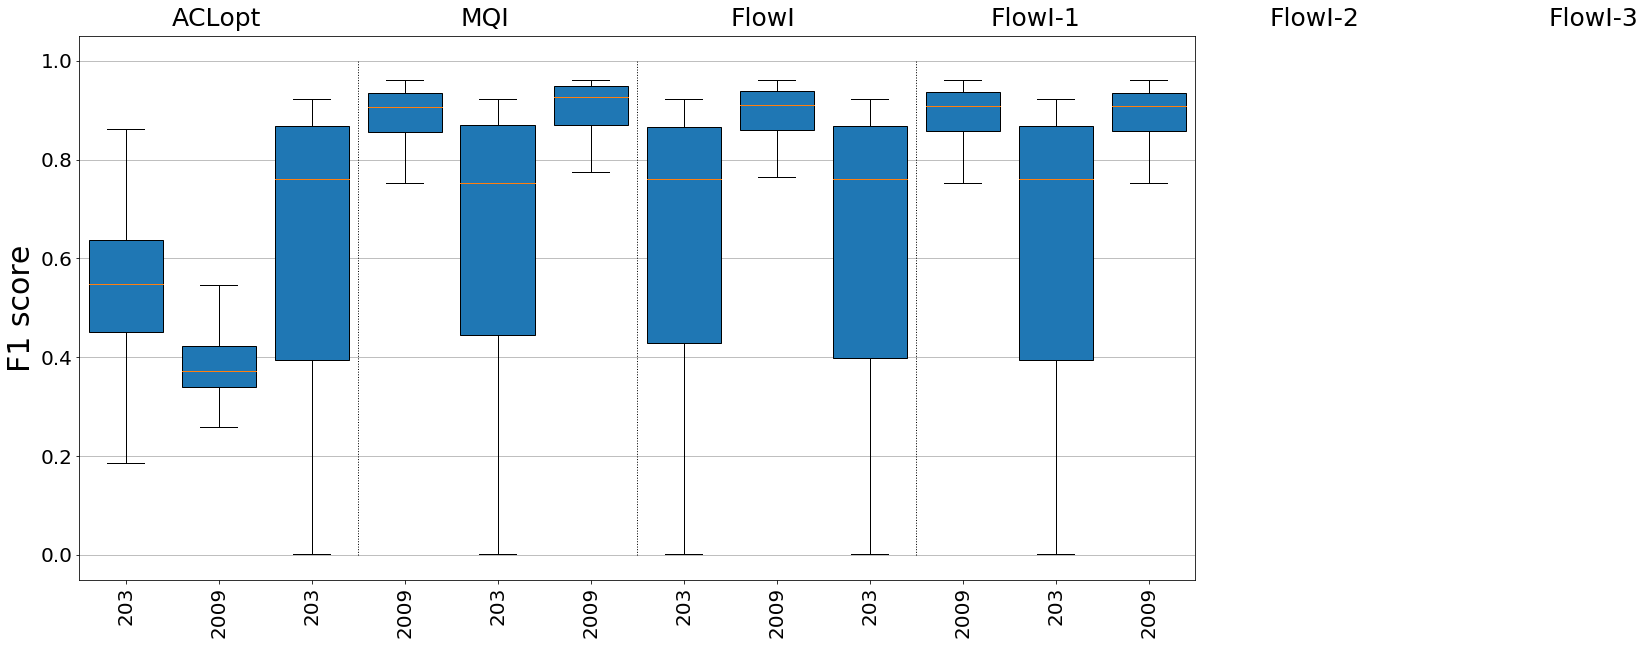

In [16]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_best_pre_acl[i,j])
    all_data.append(temp_f1)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_mqi[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('F1 score',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Rice31_f1_Optimal.png')

plt.show()

## Generate scatter plot for precision

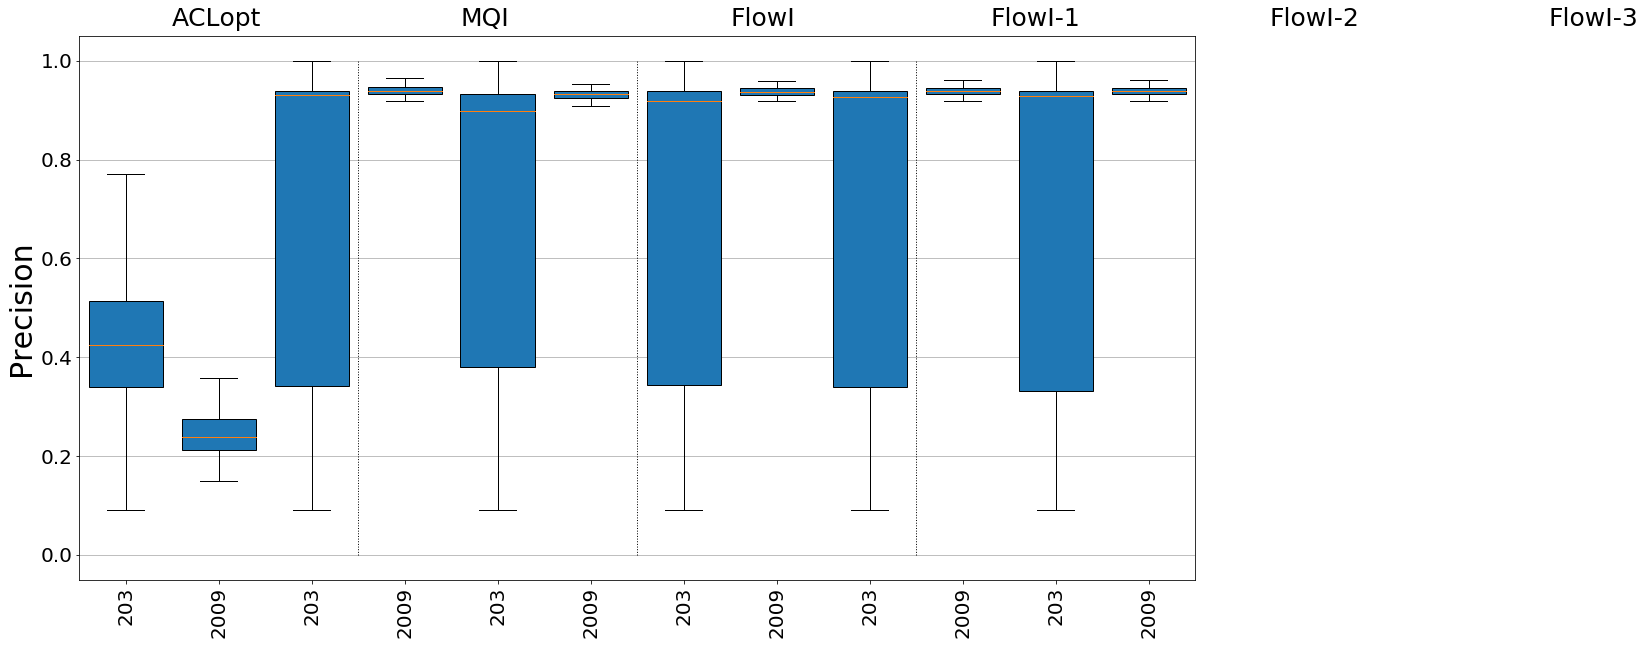

In [17]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_pre_acl[i,j])
    all_data.append(temp_pre)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1])) 
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Precision',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Rice31_precision_Optimal.png')

plt.show()

## Generate scatter plot for recall

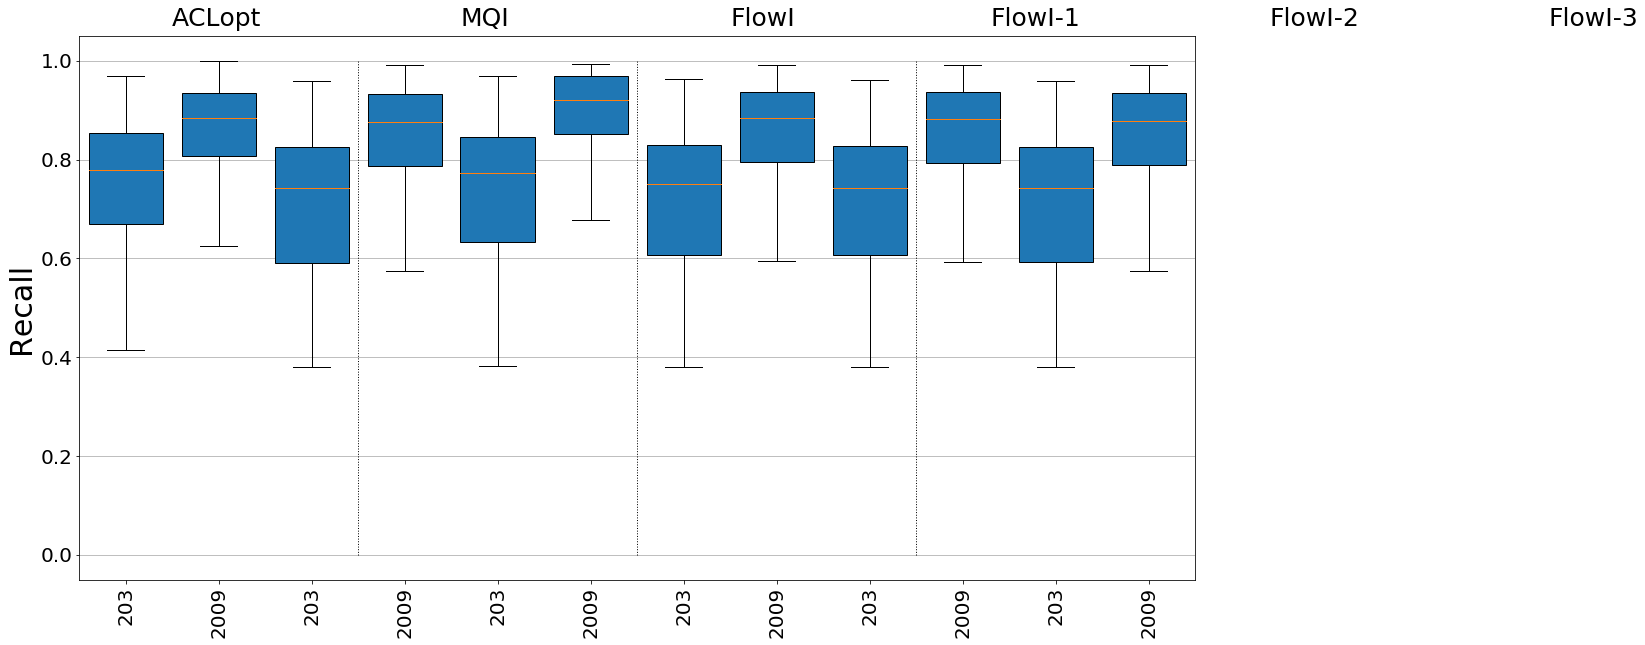

In [18]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_best_pre_acl[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_mqi[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Recall',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Rice31_recall_Optimal.png')

plt.show()

## Generate precision/recall and F1 scores

In [19]:
all_data = []
xlabels_ = []

print('Results for ACLopt')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_pre_acl[i,j])
        temp_rec.append(recall_best_pre_acl[i,j])
        temp_f1.append(f1score_best_pre_acl[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for MQI')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
        temp_rec.append(recall_mqi[i,j])
        temp_f1.append(f1_mqi[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-1')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-2')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-3')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))

Results for ACLopt
Feature: 203 Precision 0.42568443804034584 Recall 0.7787447196509776 F1 0.5478175933755138
Feature: 2009 Precision 0.23893593362415533 Recall 0.8844059887225355 F1 0.3714469412539787
Results for MQI
Feature: 203 Precision 0.9303356056633456 Recall 0.7431730569469772 F1 0.7601069161376546
Feature: 2009 Precision 0.939475342420323 Recall 0.8755590122496597 F1 0.9073774361049296
Results for FlowI
Feature: 203 Precision 0.8991680609778769 Recall 0.7733662657833383 F1 0.752485099986238
Feature: 2009 Precision 0.933061123484286 Recall 0.9209929353814246 F1 0.9261791290057517
Results for FlowI-1
Feature: 203 Precision 0.9186383569110323 Recall 0.7510676115509799 F1 0.7600857532644708
Feature: 2009 Precision 0.9375150535044559 Recall 0.8844383952297621 F1 0.9115273387584909
Results for FlowI-2
Feature: 203 Precision 0.9274365193288125 Recall 0.7433115579049422 F1 0.7600857532644708
Feature: 2009 Precision 0.9379357903608919 Recall 0.8818782811588567 F1 0.9093579451574678
Res